## Reading in Datasets

OH Notes:

Final Project:
We should use a subset of the number of teams (~100 teams) instead of all 300+ teams so we do not use all of the data. If we do use all 300+ teams, there is just too much data to work with.

Use Regularized LogisticRegression(), RFClassifier(), or SVM Classifier.

Use feature engineering to determine the top features to use in our analysis, rather than using all of the features.

Consider using only the recent years of data to determine the different seeds. This is known as block analysis when working with time series data. We would use this kind of analysis since teams change players every few years, which changes each team's win percentage.



Case Study 4:
 On regression slides:
What is: a model, and conditional expectation?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.stats
from random import choices
from sklearn import tree
import random
import folium
import os

import re
import json
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm
import seaborn as sns

In [2]:
#Reading Data In
cities = pd.read_csv('WDataFiles/WCities.csv')
game_cities = pd.read_csv('WDataFiles/WGameCities.csv')
tourney_compact= pd.read_csv('WDataFiles/WNCAATourneyCompactResults.csv')
tourney_detailed = pd.read_csv('WDataFiles/WNCAATourneyDetailedResults.csv')
tourney_seed = pd.read_csv('WDataFiles/WNCAATourneySeeds.csv')
tourney_slots = pd.read_csv('WDataFiles/WNCAATourneySlots.csv')
reg_seas_compact = pd.read_csv('WDataFiles/WRegularSeasonCompactResults.csv')
reg_seas_detail = pd.read_csv('WDataFiles/WRegularSeasonDetailedResults.csv')
seasons = pd.read_csv('WDataFiles/WSeasons.csv')
teams = pd.read_csv('WDataFiles/WTeams.csv')
team_spellings = pd.read_csv('WDataFiles/WTeamSpellings.csv',encoding = "ISO-8859-1")

# Reading In My Data Files (continues below with ncaa_all_wteams_with_states.csv)
all_wteams = pd.read_csv('WDataFiles/ncaa_all_wteams.csv')
all_lteams = pd.read_csv('WDataFiles/ncaa_all_lteams.csv')

In [3]:
# Mapping Team Ids to Team Names & cityids to city names
label_map = {"TeamID":"Team","WTeamID":"WTeam","LTeamID":"LTeam"}
team_map = teams.set_index(teams['TeamID']).drop('TeamID',axis=1).to_dict()['TeamName']
game_cities['WTeamID'] = game_cities['WTeamID'].apply(lambda x: team_map[x])
game_cities['LTeamID'] = game_cities['LTeamID'].apply(lambda x: team_map[x])
game_cities.rename(columns=label_map, inplace=True)
tourney_compact['WTeamID'] = tourney_compact['WTeamID'].apply(lambda x: team_map[x])
tourney_compact['LTeamID'] = tourney_compact['LTeamID'].apply(lambda x: team_map[x])
tourney_compact.rename(columns=label_map, inplace=True)
tourney_compact = tourney_compact[(tourney_compact.Season >=2010)&(tourney_compact.Season<2018)]
tourney_detailed['WTeamID'] = tourney_detailed['WTeamID'].apply(lambda x: team_map[x])
tourney_detailed['LTeamID'] = tourney_detailed['LTeamID'].apply(lambda x: team_map[x])
tourney_detailed.rename(columns=label_map, inplace=True)
tourney_detailed = tourney_detailed[(tourney_detailed.Season >=2010)&(tourney_detailed.Season<2018)]
tourney_seed['TeamID'] = tourney_seed['TeamID'].apply(lambda x: team_map[x])
tourney_seed.rename(columns=label_map, inplace=True)
reg_seas_compact['WTeamID'] = reg_seas_compact['WTeamID'].apply(lambda x: team_map[x])
reg_seas_compact['LTeamID'] = reg_seas_compact['LTeamID'].apply(lambda x: team_map[x])
reg_seas_compact.rename(columns=label_map, inplace=True)
reg_seas_compact = reg_seas_compact[(reg_seas_compact.Season >=2010)&(reg_seas_compact.Season<2018)]
reg_seas_detail['WTeamID'] = reg_seas_detail['WTeamID'].apply(lambda x: team_map[x])
reg_seas_detail['LTeamID'] = reg_seas_detail['LTeamID'].apply(lambda x: team_map[x])
reg_seas_detail.rename(columns=label_map, inplace=True)
reg_seas_detail = reg_seas_detail[(reg_seas_detail.Season >=2010)&(reg_seas_detail.Season<2018)]

## EDA

In [4]:
# finds the top states with the locations for games played
cities.groupby('State').describe().sort_values( ('CityID', 'count'), ascending=False)

CityID                                                             \
       count         mean         std     min      25%     50%      75%   
State                                                                     
NY      28.0  4241.214286  127.299983  4003.0  4149.25  4258.5  4337.75   
TX      25.0  4158.640000  115.517993  4001.0  4085.00  4125.0  4231.00   
CA      24.0  4225.875000  111.654480  4008.0  4154.00  4250.0  4305.75   
FL      24.0  4261.583333  138.289525  4033.0  4126.75  4250.5  4395.00   
NC      17.0  4127.235294  110.985094  4013.0  4061.00  4089.0  4138.00   
IL      16.0  4205.875000  135.115198  4055.0  4087.50  4180.5  4304.75   
LA      15.0  4242.733333  131.723990  4024.0  4163.00  4234.0  4330.00   
MS      14.0  4257.500000  113.468905  4137.0  4153.75  4230.0  4347.00   
SC      14.0  4225.500000  139.789264  4064.0  4079.75  4243.0  4316.50   
PA      12.0  4215.000000  127.123419  4005.0  4154.50  4210.0  4291.25   
VA      12.0  4184.666667   99.739053  4031.0  4117.25  4171.0  4254.50   
OH      11.0  4139.454545  131.093374  4002.0  4057.00  4080.0  4219.00   
IN      11.0  4231.272727  111.636097  4032.0  4142.50  4250.0  4331.00   
MI      11.0  4234.727273  165.003085  4010.0  4100.50  4226.0  4395.50   
NJ      10.0  4209.800000  105.917998  4017.0  4148.75  4215.5  4277.25   
TN       9.0  4162.222222   68.814566  4068.0  4083.00  4180.0  4213.00   
AL       9.0  4195.444444  118.830879  4018.0  4159.00  4218.0  4245.00   
CT       9.0  4219.888889  115.032000  4044.0  4143.00  4235.0  4338.00   
KY       7.0  4190.428571   78.057366  4041.0  4173.00  4203.0  4226.00   
MA       7.0  4152.857143  148.263761  4007.0  4045.50  4070.0  4265.00   
GA       7.0  4165.714286  129.976555  4014.0  4058.00  4176.0  4260.00   
AR       7.0  4177.142857   66.744359  4081.0  4137.50  4172.0  4222.00   
MD       7.0  4178.428571  161.413400  4011.0  4049.50  4110.0  4313.50   
HI       6.0  4303.500000  119.523638  4155.0  4202.50  4324.5  4398.50   
UT       6.0  4224.500000   89.263094  4057.0  4211.00  4255.0  4275.75   
PR       6.0  4262.500000  183.560072  4025.0  4104.50  4345.0  4395.00   
WA       6.0  4267.166667  127.281447  4069.0  4204.50  4298.5  4321.25   
AZ       6.0  4248.000000  100.993069  4120.0  4164.25  4272.5  4326.75   
MO       5.0  4256.000000  139.192313  4054.0  4174.00  4327.0  4329.00   
CO       5.0  4149.400000  120.982643  4040.0  4096.00  4121.0  4134.00   
...      ...          ...         ...     ...      ...     ...      ...   
ID       4.0  4191.000000  106.040873  4035.0  4177.50  4228.5  4242.00   
IA       4.0  4080.750000   65.753961  4006.0  4045.00  4077.5  4113.25   
OK       4.0  4296.750000   53.878722  4247.0  4252.25  4294.5  4339.00   
ME       3.0  4185.000000  140.470638  4023.0  4141.00  4259.0  4266.00   
KS       3.0  4256.000000   97.616597  4189.0  4200.00  4211.0  4289.50   
OR       3.0  4157.333333  101.869197  4086.0  4099.00  4112.0  4193.00   
MX       3.0  4202.333333  129.465568  4053.0  4162.00  4271.0  4277.00   
RI       3.0  4259.000000   71.582121  4179.0  4230.00  4281.0  4299.00   
WI       3.0  4186.333333   44.557079  4135.0  4172.00  4209.0  4212.00   
NV       3.0  4246.666667   52.700411  4188.0  4225.00  4262.0  4276.00   
WV       3.0  4149.000000   79.881162  4065.0  4111.50  4158.0  4191.00   
VI       2.0  4338.500000   12.020815  4330.0  4334.25  4338.5  4342.75   
WY       2.0  4121.000000   91.923882  4056.0  4088.50  4121.0  4153.50   
NH       2.0  4124.500000   31.819805  4102.0  4113.25  4124.5  4135.75   
NE       2.0  4225.000000   42.426407  4195.0  4210.00  4225.0  4240.00   
ND       2.0  4125.000000   11.313708  4117.0  4121.00  4125.0  4129.00   
NM       2.0  4095.500000  129.400541  4004.0  4049.75  4095.5  4141.25   
DE       2.0  4169.500000   99.702056  4099.0  4134.25  4169.5  4204.75   
ON       1.0  4442.000000         NaN  4442.0  4442.00  4442.0  4442.00   
DC       1.0  4363.000000      

In [5]:
game_cities = game_cities.merge(cities, how='left')
game_cities = game_cities.drop('CityID', axis=1)
display(len(game_cities))
# display(game_cities.loc[game_cities['City'] == 'Augusta'].head(10))
game_cities.head()

46842

,Season,DayNum,WTeam,LTeam,CRType,City,State
0,2010,11,Akron,IUPUI,Regular,Akron,OH
1,2010,11,Alabama,Tennessee Tech,Regular,Corpus Christi,TX
2,2010,11,American Univ,Howard,Regular,Washington,DC
3,2010,11,Appalachian St,Marshall,Regular,Huntington,WV
4,2010,11,Army,Wagner,Regular,West Point,NY


In [6]:
# winning teams in NCAA tournament
display(len(tourney_compact))
display(tourney_compact['WTeam'].nunique())
display(tourney_compact['WTeam'].unique())

tourney_compact = tourney_compact.reset_index(drop=True)
tourney_compact.head()

504

74

array(['Baylor', 'Dayton', 'Duke', 'Florida St', 'Georgetown', 'Georgia',
       'Gonzaga', 'Iowa', 'Kentucky', 'LSU', 'Michigan St', 'Oklahoma St',
       "St John's", 'Stanford', 'Tennessee', 'Texas A&M',
       'Ark Little Rock', 'Connecticut', 'Iowa St', 'Mississippi St',
       'Nebraska', 'Notre Dame', 'Ohio St', 'Oklahoma', 'San Diego St',
       'Temple', 'UCLA', 'Vanderbilt', 'Vermont', 'West Virginia',
       'WI Green Bay', 'Xavier', 'DePaul', 'Georgia Tech', 'Marist',
       'Marquette', 'North Carolina', 'Penn St', 'Louisville', 'Maryland',
       'Miami FL', 'Purdue', 'Rutgers', 'Arkansas', 'Kansas St',
       'South Carolina', 'California', 'Delaware', 'Florida', 'Kansas',
       'St Bonaventure', 'Creighton', 'South Florida', 'Michigan',
       'Arizona St', 'BYU', 'Syracuse', 'James Madison', 'Oregon St',
       "St Joseph's PA", 'Texas', 'FL Gulf Coast', 'Pittsburgh',
       'Princeton', 'Albany NY', 'Auburn', 'Duquesne', 'Indiana',
       'Missouri', 'S Dakota St', '

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT
0,2010,138,Baylor,69,Fresno St,55,N,0
1,2010,138,Dayton,67,TCU,66,N,0
2,2010,138,Duke,72,Hampton,37,H,0
3,2010,138,Florida St,75,Louisiana Tech,61,H,0
4,2010,138,Georgetown,62,Marist,42,N,0


In [7]:
# losing teams in NCAA tournament
display(len(tourney_compact))
display(tourney_compact['LTeam'].nunique())
display(tourney_compact['LTeam'].unique())
tourney_compact.head()

504

167

array(['Fresno St', 'TCU', 'Hampton', 'Louisiana Tech', 'Marist',
       'Tulane', 'North Carolina', 'Rutgers', 'Liberty', 'Hartford',
       'Bowling Green', 'Chattanooga', 'Princeton', 'UC Riverside',
       'Austin Peay', 'Portland St', 'Georgia Tech', 'Southern Univ',
       'Lehigh', 'MTSU', 'Northern Iowa', 'Cleveland St', 'St Francis PA',
       'S Dakota St', 'Texas', 'James Madison', 'NC State', 'DePaul',
       'Wisconsin', 'Lamar', 'Virginia', 'ETSU', 'Georgetown', 'LSU',
       "St John's", 'Oklahoma St', 'Texas A&M', 'Michigan St', 'Iowa',
       'Dayton', 'Temple', 'WI Green Bay', 'Ohio St', 'UCLA', 'Vermont',
       'Ark Little Rock', 'West Virginia', 'Vanderbilt', 'Tennessee',
       'San Diego St', 'Georgia', 'Gonzaga', 'Iowa St', 'Mississippi St',
       'Nebraska', 'Notre Dame', 'Duke', 'Xavier', 'Florida St',
       'Kentucky', 'Baylor', 'Oklahoma', 'Stanford', 'Navy', 'TN Martin',
       'Utah', 'UCF', 'Texas Tech', 'UC Davis', 'Arizona St', 'Stetson',
       'Mont

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT
0,2010,138,Baylor,69,Fresno St,55,N,0
1,2010,138,Dayton,67,TCU,66,N,0
2,2010,138,Duke,72,Hampton,37,H,0
3,2010,138,Florida St,75,Louisiana Tech,61,H,0
4,2010,138,Georgetown,62,Marist,42,N,0


In [8]:
# get corresponding city and state for each NCAA tournament game
game_cities = game_cities.merge(cities, how='left')
game_cities = game_cities.drop('CityID', axis=1)

# get only the NCAA tournament games
game_cities = game_cities.loc[game_cities['CRType'] == 'NCAA']

# helps determine the city and state of each team
display(len(game_cities))
# display(game_cities.loc[game_cities['WTeam'] == 'Washington'].head())
# display(game_cities.loc[game_cities['LTeam'] == 'Washington'].head())

# extra data displays
# display(game_cities.loc[game_cities['City'] == 'Dayton'].head(10))
game_cities.head()

567

,Season,DayNum,WTeam,LTeam,CRType,City,State
5034,2010,138,Baylor,Fresno St,NCAA,Berkeley,CA
5035,2010,138,Dayton,TCU,NCAA,Knoxville,TN
5036,2010,138,Duke,Hampton,NCAA,Durham,NC
5037,2010,138,Florida St,Louisiana Tech,NCAA,Tallahassee,FL
5038,2010,138,Georgetown,Marist,NCAA,Berkeley,CA


In [9]:
display(len(tourney_detailed))
display(tourney_detailed['WTeam'].nunique())
tourney_detailed.head()

504

74

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,138,Baylor,69,Fresno St,55,N,0,28,57,...,34,3,5,17,19,12,18,4,1,18
1,2010,138,Dayton,67,TCU,66,N,0,23,59,...,27,14,15,18,26,8,8,8,6,22
2,2010,138,Duke,72,Hampton,37,H,0,26,57,...,15,3,8,10,21,4,16,6,4,20
3,2010,138,Florida St,75,Louisiana Tech,61,H,0,25,63,...,20,17,22,16,21,13,16,5,4,24
4,2010,138,Georgetown,62,Marist,42,N,0,24,68,...,26,11,17,16,22,9,10,3,4,12


The game dates in this dataset are expressed in relative terms, as the number of days since the start of the regular season, and aligned for each season so that day number #133 is the Monday right before the tournament, when team selections are made. During any given season, day number zero is defined to be exactly 19 weeks earlier than Selection Monday, so Day #0 is a Monday in late October or early November such that Day #132 is Selection Sunday (for the men's tournament) and Day #133 is Selection Monday (for the women's tournament).

This doesn't necessarily mean that the regular season will always start exactly on Day #0; in fact, during the past decade, regular season games typically start being played on a Friday that is either Day #4 or Day #11, but further back there was more variety.

In [10]:
seasons[7:]

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
7,2005,11/1/2004,Chattanooga,Tempe,KansasCity,Philadelphia
8,2006,10/31/2005,Albuquerque,Cleveland,Bridgeport,San Antonio
9,2007,10/30/2006,Dallas,Dayton,Fresno,Greensboro
10,2008,11/5/2007,Greensboro,Spokane,NewOrleans,OklahomaCity
11,2009,11/3/2008,Berkeley,Trenton,OklahomaCity,Raleigh
12,2010,11/2/2009,Dayton,Memphis,KansasCity,Sacramento
13,2011,11/1/2010,Dallas,Spokane,Dayton,Philadelphia
14,2012,10/31/2011,DesMoines,Fresno,Kingston,Raleigh
15,2013,11/5/2012,Bridgeport,Norfolk,OklahomaCity,Spokane
16,2014,11/4/2013,Lincoln,Stanford,Louisville,NotreDame


In [11]:
# reg_seas_compact.head()

In [12]:
# reg_seas_detail.head()

In [13]:
# team_spellings.head()

In [14]:
# tourney_compact.head()
unique_wteams = tourney_compact['WTeam'].unique().tolist()
# pd.DataFrame(unique_wteams, columns=['short name']).head()

In [15]:
team_spellings.merge(teams, how='left').head()

,TeamNameSpelling,TeamID,TeamName
0,a&m-corpus chris,3394,TAM C. Christi
1,a&m-corpus christi,3394,TAM C. Christi
2,abilene chr,3101,Abilene Chr
3,abilene christian,3101,Abilene Chr
4,abilene-christian,3101,Abilene Chr


## GeoJSON - Plotting Each Institution's Lat-Long Pair

In [16]:
tourney_compact['WTeam'] = tourney_compact['WTeam'].str.lower()
tourney_compact['LTeam'] = tourney_compact['LTeam'].str.lower()
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r' +', ' ', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r' +', ' ', x))

# changing names to match all winning teams
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'lsu', 'louisiana', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'lsu', 'louisiana', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'ark little rock', 'arkansas at little rock', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'ark little rock', 'arkansas at little rock', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'ucla', 'los angeles', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'ucla', 'los angeles', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'wi green bay', 'wisconsin green bay', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'wi green bay', 'wisconsin green bay', x))

# changing names to match all losing teams
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'fresno st', 'fresno', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'fresno st', 'fresno', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'tcu', 'texas christian', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'tcu', 'texas christian', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'uc riverside', 'riverside', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'uc riverside', 'riverside', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'georgia tech', 'georgia institute', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'georgia tech', 'georgia institute', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'mtsu', 'montana state', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'mtsu', 'montana state', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'st francis pa', 'st francis', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'st francis pa', 'st francis', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r's dakota st', 'south dakota state', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r's dakota st', 'south dakota state', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'nc state', 'north carolina state', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'nc state', 'north carolina state', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'etsu', 'east tennessee state', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'etsu', 'east tennessee state', x))

# for 2011 season
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'penn st', 'pennsylvania state', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'penn st', 'pennsylvania state', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'miami fl', 'miami', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'miami fl', 'miami', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'navy', 'military', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'navy', 'military', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'tn martin', 'martin', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'tn martin', 'martin', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'ucf', 'central florida', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'ucf', 'central florida', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'uc davis', 'davis', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'uc davis', 'davis', x))

# for 2017 season
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'w illinois', 'western illinois', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'w illinois', 'western illinois', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'wku', 'western kentucky', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'wku', 'western kentucky', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'long beach st', 'long beach', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'long beach st', 'long beach', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'unc asheville', 'asheville', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'unc asheville', 'asheville', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'cent arkansas', 'central arkansas', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'cent arkansas', 'central arkansas', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'tx southern', 'texas southern', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'tx southern', 'texas southern', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'albany ny', 'albany', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'albany ny', 'albany', x))
tourney_compact['WTeam'] = tourney_compact['WTeam'].apply(lambda x: re.sub(r'fl gulf coast', 'florida gulf coast', x))
tourney_compact['LTeam'] = tourney_compact['LTeam'].apply(lambda x: re.sub(r'fl gulf coast', 'florida gulf coast', x))

In [17]:
display(len(tourney_compact))
tourney_compact.head()

504

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT
0,2010,138,baylor,69,fresno,55,N,0
1,2010,138,dayton,67,texas christian,66,N,0
2,2010,138,duke,72,hampton,37,H,0
3,2010,138,florida st,75,louisiana tech,61,H,0
4,2010,138,georgetown,62,marist,42,N,0


In [18]:
# working with just the 2010 season of the NCAA tournament
tourney_2010 = tourney_compact.loc[tourney_compact['Season'] == 2010]
display(len(tourney_2010))
tourney_2010.head()

63

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT
0,2010,138,baylor,69,fresno,55,N,0
1,2010,138,dayton,67,texas christian,66,N,0
2,2010,138,duke,72,hampton,37,H,0
3,2010,138,florida st,75,louisiana tech,61,H,0
4,2010,138,georgetown,62,marist,42,N,0


In [19]:
all_wteams.columns = ['unitid', 'institution name', 'year', 'longitude', 'latitude']
all_wteams['institution name'] = all_wteams['institution name'].str.lower()
all_wteams['institution name'] = all_wteams['institution name'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
all_wteams['institution name'] = all_wteams['institution name'].apply(lambda x: re.sub(r' +', ' ', x))

# words = ['university', 'of']

all_wteams.head()

,unitid,institution name,year,longitude,latitude
0,100858,auburn university,2017,-85.488258,32.599378
1,104151,arizona state university tempe,2017,-111.934383,33.417721
2,106245,university of arkansas at little rock,2017,-92.339778,34.723254
3,106397,university of arkansas,2017,-94.176981,36.070009
4,110635,university of california berkeley,2017,-122.260463,37.871918


In [20]:
updated_all_wteams = all_wteams[['latitude', 'longitude']]
updated_all_wteams.head()

,latitude,longitude
0,32.599378,-85.488258
1,33.417721,-111.934383
2,34.723254,-92.339778
3,36.070009,-94.176981
4,37.871918,-122.260463


In [23]:
updated_all_wteams['coordinates'] = [ 
    [ 
        updated_all_wteams['longitude'].values[index], 
        updated_all_wteams['latitude'].values[index] 
    ] for index in range(len(updated_all_wteams)) 
]
updated_all_wteams.head()

C:\Users\redwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,latitude,longitude,coordinates
0,32.599378,-85.488258,"[-85.488258, 32.599378]"
1,33.417721,-111.934383,"[-111.93438300000001, 33.417721]"
2,34.723254,-92.339778,"[-92.33977800000001, 34.723254]"
3,36.070009,-94.176981,"[-94.17698100000001, 36.070009000000006]"
4,37.871918,-122.260463,"[-122.26046299999999, 37.871918]"


In [24]:
# changing column names for losing teams in NCAA tournament
all_lteams.columns = ['unitid', 'institution name', 'year', 'longitude', 'latitude']
all_lteams['institution name'] = all_lteams['institution name'].str.lower()
all_lteams['institution name'] = all_lteams['institution name'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
all_lteams['institution name'] = all_lteams['institution name'].apply(lambda x: re.sub(r' +', ' ', x))
all_lteams.head()

,unitid,institution name,year,longitude,latitude
0,100724,alabama state university,2017,-86.295677,32.364317
1,100858,auburn university,2017,-85.488258,32.599378
2,102049,samford university,2017,-86.791799,33.464128
3,102368,troy university,2017,-85.957094,31.800672
4,106245,university of arkansas at little rock,2017,-92.339778,34.723254


In [25]:
updated_all_lteams = all_lteams[['latitude', 'longitude']]
display(len(updated_all_lteams))
updated_all_lteams.head()

161

,latitude,longitude
0,32.364317,-86.295677
1,32.599378,-85.488258
2,33.464128,-86.791799
3,31.800672,-85.957094
4,34.723254,-92.339778


In [26]:
updated_all_lteams['coordinates'] = [ 
    [ 
        updated_all_lteams['longitude'].values[index], 
        updated_all_lteams['latitude'].values[index] 
    ] for index in range(len(updated_all_lteams)) 
]
updated_all_lteams.head()

C:\Users\redwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,latitude,longitude,coordinates
0,32.364317,-86.295677,"[-86.295677, 32.364317]"
1,32.599378,-85.488258,"[-85.488258, 32.599378]"
2,33.464128,-86.791799,"[-86.791799, 33.464128]"
3,31.800672,-85.957094,"[-85.957094, 31.800672]"
4,34.723254,-92.339778,"[-92.33977800000001, 34.723254]"


In [27]:
all_teams = pd.concat([all_wteams, all_lteams]).reset_index().drop('index', axis=1)
all_teams.head()

,unitid,institution name,year,longitude,latitude
0,100858,auburn university,2017,-85.488258,32.599378
1,104151,arizona state university tempe,2017,-111.934383,33.417721
2,106245,university of arkansas at little rock,2017,-92.339778,34.723254
3,106397,university of arkansas,2017,-94.176981,36.070009
4,110635,university of california berkeley,2017,-122.260463,37.871918


In [28]:
def get_wteams_with_coords(tourney_df):
    wteams_df = pd.DataFrame()

    for index in range(len(tourney_df)):
        wteam = tourney_df['WTeam'][index]
        for all_index in range(len(all_teams)):
            if wteam in all_teams['institution name'].values.tolist()[all_index]:
                wteams_df = wteams_df.append(all_teams.iloc[all_index])
                break
    
    wteams_df = wteams_df.reset_index(drop=True)
    wteams_df['wteam_coord'] = [ 
        [ 
            wteams_df['longitude'].values[index], 
            wteams_df['latitude'].values[index] 
        ] for index in range(len(wteams_df)) 
    ]
    return wteams_df

In [29]:
wteams_df = get_wteams_with_coords(tourney_2010)
display(len(wteams_df))
display(wteams_df.head())

63

,institution name,latitude,longitude,unitid,year,wteam_coord
0,baylor university,31.548960,-97.117641,223232.0,2017.0,"[-97.117641, 31.548959999999997]"
1,university of dayton,39.739547,-84.176113,202480.0,2017.0,"[-84.176113, 39.739546999999995]"
2,duke university,36.001135,-78.937624,198419.0,2017.0,"[-78.937624, 36.001135]"
3,florida state university,30.440756,-84.291921,134097.0,2017.0,"[-84.291921, 30.440756]"
4,georgetown college,38.207615,-84.553767,156745.0,2017.0,"[-84.55376700000001, 38.207615000000004]"


In [30]:
tourney_2010_wteam_coords = pd.concat([tourney_2010, wteams_df], axis=1)
tourney_2010_wteam_coords.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,unitid,year,wteam_coord
0,2010,138,baylor,69,fresno,55,N,0,baylor university,31.548960,-97.117641,223232.0,2017.0,"[-97.117641, 31.548959999999997]"
1,2010,138,dayton,67,texas christian,66,N,0,university of dayton,39.739547,-84.176113,202480.0,2017.0,"[-84.176113, 39.739546999999995]"
2,2010,138,duke,72,hampton,37,H,0,duke university,36.001135,-78.937624,198419.0,2017.0,"[-78.937624, 36.001135]"
3,2010,138,florida st,75,louisiana tech,61,H,0,florida state university,30.440756,-84.291921,134097.0,2017.0,"[-84.291921, 30.440756]"
4,2010,138,georgetown,62,marist,42,N,0,georgetown college,38.207615,-84.553767,156745.0,2017.0,"[-84.55376700000001, 38.207615000000004]"


In [174]:
# # create a route centered at the mean lat/long
# my_route = folium.Map(location=[updated_all_wteams.latitude.mean(), updated_all_wteams.longitude.mean()], zoom_start=14)

# # a list of line segments
# folium.PolyLine(updated_all_wteams.values.tolist()).add_to(my_route)

# my_route

In [32]:
def get_lteams_with_coords(tourney_df):
    lteams_df = pd.DataFrame()

    for index in range(len(tourney_df)):
        lteam = tourney_df['LTeam'][index]
        for all_index in range(len(all_teams)):
            if lteam in all_teams['institution name'].values.tolist()[all_index]:
                lteams_df = lteams_df.append(all_teams.iloc[all_index])
                break
    
    lteams_df = lteams_df.reset_index(drop=True)
    lteams_df['lteam_coord'] = [ 
        [ 
            lteams_df['longitude'].values[index], 
            lteams_df['latitude'].values[index] 
        ] for index in range(len(lteams_df)) 
    ]
    return lteams_df

In [33]:
lteams_df = get_lteams_with_coords(tourney_2010)
display(len(lteams_df))
display(lteams_df.head())

63

,institution name,latitude,longitude,unitid,year,lteam_coord
0,california state university fresno,36.814477,-119.748258,110556.0,2017.0,"[-119.748258, 36.814477000000004]"
1,texas christian university,32.709568,-97.361537,228875.0,2017.0,"[-97.361537, 32.709568]"
2,hampton university,37.019944,-76.339161,232265.0,2017.0,"[-76.339161, 37.019944]"
3,louisiana tech university,32.528297,-92.649963,159647.0,2017.0,"[-92.649963, 32.528296999999995]"
4,marist college,41.720937,-73.935484,192819.0,2017.0,"[-73.935484, 41.720937]"


In [34]:
tourney_2010_lteam_coords = pd.concat([tourney_2010, lteams_df], axis=1)
tourney_2010_lteam_coords.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,unitid,year,lteam_coord
0,2010,138,baylor,69,fresno,55,N,0,california state university fresno,36.814477,-119.748258,110556.0,2017.0,"[-119.748258, 36.814477000000004]"
1,2010,138,dayton,67,texas christian,66,N,0,texas christian university,32.709568,-97.361537,228875.0,2017.0,"[-97.361537, 32.709568]"
2,2010,138,duke,72,hampton,37,H,0,hampton university,37.019944,-76.339161,232265.0,2017.0,"[-76.339161, 37.019944]"
3,2010,138,florida st,75,louisiana tech,61,H,0,louisiana tech university,32.528297,-92.649963,159647.0,2017.0,"[-92.649963, 32.528296999999995]"
4,2010,138,georgetown,62,marist,42,N,0,marist college,41.720937,-73.935484,192819.0,2017.0,"[-73.935484, 41.720937]"


In [35]:
tourney_2010_teams_coords = pd.concat([tourney_2010_wteam_coords, lteams_df], axis=1)
tourney_2010_teams_coords = tourney_2010_teams_coords.drop(['unitid', 'year'], axis=1)
tourney_2010_teams_coords.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,wteam_coord,institution name,latitude,longitude,lteam_coord
0,2010,138,baylor,69,fresno,55,N,0,baylor university,31.548960,-97.117641,"[-97.117641, 31.548959999999997]",california state university fresno,36.814477,-119.748258,"[-119.748258, 36.814477000000004]"
1,2010,138,dayton,67,texas christian,66,N,0,university of dayton,39.739547,-84.176113,"[-84.176113, 39.739546999999995]",texas christian university,32.709568,-97.361537,"[-97.361537, 32.709568]"
2,2010,138,duke,72,hampton,37,H,0,duke university,36.001135,-78.937624,"[-78.937624, 36.001135]",hampton university,37.019944,-76.339161,"[-76.339161, 37.019944]"
3,2010,138,florida st,75,louisiana tech,61,H,0,florida state university,30.440756,-84.291921,"[-84.291921, 30.440756]",louisiana tech university,32.528297,-92.649963,"[-92.649963, 32.528296999999995]"
4,2010,138,georgetown,62,marist,42,N,0,georgetown college,38.207615,-84.553767,"[-84.55376700000001, 38.207615000000004]",marist college,41.720937,-73.935484,"[-73.935484, 41.720937]"


In [36]:
# # create a route centered at the mean lat/long
# my_route2 = folium.Map(location=[updated_all_lteams.latitude.mean(), updated_all_lteams.longitude.mean()], zoom_start=14)

# # a list of line segments
# folium.PolyLine(updated_all_lteams.values.tolist()).add_to(my_route2)

# my_route2

In [37]:
# finding the distance that each team travelled for the first game
game_cities.head()

,Season,DayNum,WTeam,LTeam,CRType,City,State
5034,2010,138,Baylor,Fresno St,NCAA,Berkeley,CA
5035,2010,138,Dayton,TCU,NCAA,Knoxville,TN
5036,2010,138,Duke,Hampton,NCAA,Durham,NC
5037,2010,138,Florida St,Louisiana Tech,NCAA,Tallahassee,FL
5038,2010,138,Georgetown,Marist,NCAA,Berkeley,CA


In [38]:
copy_gc = game_cities.copy()
copy_gc['city&state'] = copy_gc['City'] + copy_gc['State']
copy_gc['WTeam'] = copy_gc['WTeam'].str.lower()
copy_gc['LTeam'] = copy_gc['LTeam'].str.lower()
copy_gc['WTeam'] = copy_gc['WTeam'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
copy_gc['WTeam'] = copy_gc['WTeam'].apply(lambda x: re.sub(r' +', ' ', x))
copy_gc['LTeam'] = copy_gc['LTeam'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
copy_gc['LTeam'] = copy_gc['LTeam'].apply(lambda x: re.sub(r' +', ' ', x))
copy_gc.head()

,Season,DayNum,WTeam,LTeam,CRType,City,State,city&state
5034,2010,138,baylor,fresno st,NCAA,Berkeley,CA,BerkeleyCA
5035,2010,138,dayton,tcu,NCAA,Knoxville,TN,KnoxvilleTN
5036,2010,138,duke,hampton,NCAA,Durham,NC,DurhamNC
5037,2010,138,florida st,louisiana tech,NCAA,Tallahassee,FL,TallahasseeFL
5038,2010,138,georgetown,marist,NCAA,Berkeley,CA,BerkeleyCA


In [39]:
# reading in US cities dataset
# from: https://simplemaps.com/data/us-cities
us_cities = pd.read_csv('WDataFiles/us_cities.csv')
us_cities = us_cities[['city', 'city_ascii', 'state_id', 'state_name', 'lat', 'lng']]

In [40]:
copy_usc = us_cities.copy()
copy_usc['city&state'] = copy_usc['city'] + copy_usc['state_id']
copy_usc = copy_usc[['lat', 'lng', 'city&state']]
copy_usc.columns = ['latitude', 'longitude', 'city&state']
display(len(copy_usc))
copy_usc.head()

36651

,latitude,longitude,city&state
0,47.1443,-122.1408,Prairie RidgeWA
1,48.5602,-122.4311,EdisonWA
2,46.6085,-121.6702,PackwoodWA
3,47.5862,-122.5482,Wautauga BeachWA
4,47.5207,-122.5196,HarperWA


In [41]:
merged_gc_usc = copy_gc.merge(copy_usc, how='left')
display(len(merged_gc_usc))
merged_gc_usc.head()

567

,Season,DayNum,WTeam,LTeam,CRType,City,State,city&state,latitude,longitude
0,2010,138,baylor,fresno st,NCAA,Berkeley,CA,BerkeleyCA,37.8723,-122.2760
1,2010,138,dayton,tcu,NCAA,Knoxville,TN,KnoxvilleTN,35.9690,-83.9498
2,2010,138,duke,hampton,NCAA,Durham,NC,DurhamNC,35.9801,-78.9045
3,2010,138,florida st,louisiana tech,NCAA,Tallahassee,FL,TallahasseeFL,30.4549,-84.2527
4,2010,138,georgetown,marist,NCAA,Berkeley,CA,BerkeleyCA,37.8723,-122.2760


### NOTE: us_cities dataset did not include Notre Dame, IN, and University Park, PA, so I found the lat-long pairs of those cities from additional resources. Here are the resources:
##### Notre Dame: 41.702358, -86.234192
##### ---> https://www.latlong.net/place/hesburgh-library-notre-dame-indiana-22045.html
##### University Park: 40.812195, -77.856102
##### ---> https://www.latlong.net/place/beaver-stadium-university-park-pa-usa-23019.html

In [42]:
notre_dame = [41.702358, -86.234192, 'Notre DameIN']
notre_dame = pd.DataFrame(notre_dame).T
notre_dame.columns = ['latitude', 'longitude', 'city&state']
notre_dame

,latitude,longitude,city&state
0,41.7024,-86.2342,Notre DameIN


In [43]:
univ_park = [40.812195, -77.856102, 'University ParkPA']
univ_park = pd.DataFrame(univ_park).T
univ_park.columns = ['latitude', 'longitude', 'city&state']
univ_park

,latitude,longitude,city&state
0,40.8122,-77.8561,University ParkPA


In [44]:
copy_usc = copy_usc.append(notre_dame)
copy_usc = copy_usc.append(univ_park)
display(len(copy_usc))
copy_usc.head()

36653

,latitude,longitude,city&state
0,47.1443,-122.141,Prairie RidgeWA
1,48.5602,-122.431,EdisonWA
2,46.6085,-121.67,PackwoodWA
3,47.5862,-122.548,Wautauga BeachWA
4,47.5207,-122.52,HarperWA


In [45]:
# check that all city&state values have a lat-long pair
merged_gc_usc = copy_gc.merge(copy_usc, how='left')
# merged_gc_usc['WTeam'] = merged_gc_usc['WTeam'].str.lower()
# merged_gc_usc['LTeam'] = merged_gc_usc['LTeam'].str.lower()
merged_gc_usc.head()

,Season,DayNum,WTeam,LTeam,CRType,City,State,city&state,latitude,longitude
0,2010,138,baylor,fresno st,NCAA,Berkeley,CA,BerkeleyCA,37.8723,-122.276
1,2010,138,dayton,tcu,NCAA,Knoxville,TN,KnoxvilleTN,35.969,-83.9498
2,2010,138,duke,hampton,NCAA,Durham,NC,DurhamNC,35.9801,-78.9045
3,2010,138,florida st,louisiana tech,NCAA,Tallahassee,FL,TallahasseeFL,30.4549,-84.2527
4,2010,138,georgetown,marist,NCAA,Berkeley,CA,BerkeleyCA,37.8723,-122.276


In [46]:
game_cities_coord = merged_gc_usc[['latitude', 'longitude']]
# game_cities_coord.columns = ['latitude', 'longitude']
display(len(game_cities_coord))
game_cities_coord.head()

567

,latitude,longitude
0,37.8723,-122.276
1,35.969,-83.9498
2,35.9801,-78.9045
3,30.4549,-84.2527
4,37.8723,-122.276


In [47]:
game_cities_coord['coordinates'] = [ 
    [ 
        game_cities_coord['longitude'].values[index], 
        game_cities_coord['latitude'].values[index] 
    ] for index in range(len(game_cities_coord)) 
]
game_cities_coord.head()

C:\Users\redwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,latitude,longitude,coordinates
0,37.8723,-122.276,"[-122.276, 37.8723]"
1,35.969,-83.9498,"[-83.9498, 35.969]"
2,35.9801,-78.9045,"[-78.9045, 35.9801]"
3,30.4549,-84.2527,"[-84.2527, 30.4549]"
4,37.8723,-122.276,"[-122.276, 37.8723]"


In [48]:
# # create a route centered at the mean lat/long
# my_route3 = folium.Map(location=[game_cities_coord.latitude.mean(), game_cities_coord.longitude.mean()], zoom_start=14)

# # a list of line segments
# folium.PolyLine(game_cities_coord.values.tolist()).add_to(my_route3)

# my_route3

In [49]:
display(len(merged_gc_usc))
merged_gc_usc.head()

567

,Season,DayNum,WTeam,LTeam,CRType,City,State,city&state,latitude,longitude
0,2010,138,baylor,fresno st,NCAA,Berkeley,CA,BerkeleyCA,37.8723,-122.276
1,2010,138,dayton,tcu,NCAA,Knoxville,TN,KnoxvilleTN,35.969,-83.9498
2,2010,138,duke,hampton,NCAA,Durham,NC,DurhamNC,35.9801,-78.9045
3,2010,138,florida st,louisiana tech,NCAA,Tallahassee,FL,TallahasseeFL,30.4549,-84.2527
4,2010,138,georgetown,marist,NCAA,Berkeley,CA,BerkeleyCA,37.8723,-122.276


In [50]:
tourney_2010_game_locations = merged_gc_usc.loc[merged_gc_usc['Season'] == 2010]
tourney_2010_game_locations = tourney_2010_game_locations[['City', 'State', 'city&state', 'latitude', 'longitude']]
tourney_2010_game_locations.head()

,City,State,city&state,latitude,longitude
0,Berkeley,CA,BerkeleyCA,37.8723,-122.276
1,Knoxville,TN,KnoxvilleTN,35.969,-83.9498
2,Durham,NC,DurhamNC,35.9801,-78.9045
3,Tallahassee,FL,TallahasseeFL,30.4549,-84.2527
4,Berkeley,CA,BerkeleyCA,37.8723,-122.276


In [51]:
tourney_2010_game_locations['game_loc_coord'] = [ 
    [ 
        tourney_2010_game_locations['longitude'].values[index], 
        tourney_2010_game_locations['latitude'].values[index] 
    ] for index in range(len(tourney_2010_game_locations)) 
]
tourney_2010_game_locations.head()

,City,State,city&state,latitude,longitude,game_loc_coord
0,Berkeley,CA,BerkeleyCA,37.8723,-122.276,"[-122.276, 37.8723]"
1,Knoxville,TN,KnoxvilleTN,35.969,-83.9498,"[-83.9498, 35.969]"
2,Durham,NC,DurhamNC,35.9801,-78.9045,"[-78.9045, 35.9801]"
3,Tallahassee,FL,TallahasseeFL,30.4549,-84.2527,"[-84.2527, 30.4549]"
4,Berkeley,CA,BerkeleyCA,37.8723,-122.276,"[-122.276, 37.8723]"


In [52]:
tourney_2010_final = pd.concat([tourney_2010_teams_coords, tourney_2010_game_locations], axis=1)
tourney_2010_final.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,...,institution name,latitude,longitude,lteam_coord,City,State,city&state,latitude,longitude,game_loc_coord
0,2010,138,baylor,69,fresno,55,N,0,baylor university,31.548960,...,california state university fresno,36.814477,-119.748258,"[-119.748258, 36.814477000000004]",Berkeley,CA,BerkeleyCA,37.8723,-122.276,"[-122.276, 37.8723]"
1,2010,138,dayton,67,texas christian,66,N,0,university of dayton,39.739547,...,texas christian university,32.709568,-97.361537,"[-97.361537, 32.709568]",Knoxville,TN,KnoxvilleTN,35.969,-83.9498,"[-83.9498, 35.969]"
2,2010,138,duke,72,hampton,37,H,0,duke university,36.001135,...,hampton university,37.019944,-76.339161,"[-76.339161, 37.019944]",Durham,NC,DurhamNC,35.9801,-78.9045,"[-78.9045, 35.9801]"
3,2010,138,florida st,75,louisiana tech,61,H,0,florida state university,30.440756,...,louisiana tech university,32.528297,-92.649963,"[-92.649963, 32.528296999999995]",Tallahassee,FL,TallahasseeFL,30.4549,-84.2527,"[-84.2527, 30.4549]"
4,2010,138,georgetown,62,marist,42,N,0,georgetown college,38.207615,...,marist college,41.720937,-73.935484,"[-73.935484, 41.720937]",Berkeley,CA,BerkeleyCA,37.8723,-122.276,"[-122.276, 37.8723]"


In [53]:
tourney_2010_all_coords = tourney_2010_final[['wteam_coord', 'lteam_coord', 'game_loc_coord']]
tourney_2010_all_coords.head()

,wteam_coord,lteam_coord,game_loc_coord
0,"[-97.117641, 31.548959999999997]","[-119.748258, 36.814477000000004]","[-122.276, 37.8723]"
1,"[-84.176113, 39.739546999999995]","[-97.361537, 32.709568]","[-83.9498, 35.969]"
2,"[-78.937624, 36.001135]","[-76.339161, 37.019944]","[-78.9045, 35.9801]"
3,"[-84.291921, 30.440756]","[-92.649963, 32.528296999999995]","[-84.2527, 30.4549]"
4,"[-84.55376700000001, 38.207615000000004]","[-73.935484, 41.720937]","[-122.276, 37.8723]"


In [54]:
def haversine(df):
    '''haversine in miles'''
    rads = df.applymap(np.deg2rad)

    lat1 = rads['latitude']
    long1 = rads['longitude']

    # To take successive difference, shift arrays up by one.
    lat2 = rads['latitude'].iloc[1:].reset_index(drop=True)
    long2 = rads['longitude'].iloc[1:].reset_index(drop=True)

    lat = lat2 - lat1
    long = long2 - long1
    
    inside = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(long * 0.5) ** 2
    return 2 * 6371.0088 * np.arcsin(np.sqrt(inside)) * 0.621

In [55]:
def get_distances(tourney_df_all_coords):
    dist_wteam_list = []
    dist_lteam_list = []
    wteam_coords = tourney_df_all_coords['wteam_coord'].values.tolist()
    lteam_coords = tourney_df_all_coords['lteam_coord'].values.tolist()
    game_loc_coords = tourney_df_all_coords['game_loc_coord'].values.tolist()

    for index in range(len(tourney_df_all_coords)):
        dist_wteam_df = pd.DataFrame([wteam_coords[index], game_loc_coords[index]], columns=['latitude', 'longitude'])
        dist_wteam = haversine(dist_wteam_df).sum()
        dist_lteam_df = pd.DataFrame([lteam_coords[index], game_loc_coords[index]], columns=['latitude', 'longitude'])
        dist_lteam = haversine(dist_lteam_df).sum()
        dist_wteam_list.append(dist_wteam)
        dist_lteam_list.append(dist_lteam)
        
    dist_wteam_df = pd.DataFrame(dist_wteam_list, columns=['dist_wteam'])
    dist_lteam_df = pd.DataFrame(dist_lteam_list, columns=['dist_lteam'])
    return dist_wteam_df, dist_lteam_df

In [56]:
dist_wteam_df, dist_lteam_df = get_distances(tourney_2010_all_coords)
display(dist_wteam_df.head())
display(dist_lteam_df.head())

,dist_wteam
0,1740.981153
1,31.128287
2,2.304251
3,2.710048
4,2604.795484


,dist_lteam
0,178.551039
1,925.736490
2,177.802553
3,579.766893
4,3336.251260


In [57]:
tourney_2010_final_with_dist = pd.concat([tourney_2010_final, dist_wteam_df, dist_lteam_df], axis=1)
tourney_2010_final_with_dist.T

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
Season,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010,...,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010
DayNum,138,138,138,138,138,138,138,138,138,138,...,146,146,146,147,147,148,148,153,153,155
WTeam,baylor,dayton,duke,florida st,georgetown,georgia,gonzaga,iowa,kentucky,louisiana,...,florida st,kentucky,oklahoma,baylor,stanford,connecticut,oklahoma,connecticut,stanford,connecticut
WScore,69,67,72,75,62,64,82,70,83,60,...,74,76,77,51,55,90,88,70,73,53
LTeam,fresno,texas christian,hampton,louisiana tech,marist,tulane,north carolina,rutgers,liberty,hartford,...,mississippi st,nebraska,notre dame,duke,xavier,florida st,kentucky,baylor,oklahoma,stanford
LScore,55,66,37,61,42,59,76,63,77,39,...,71,67,72,48,53,50,68,50,66,47
WLoc,N,N,H,H,N,N,H,N,H,N,...,N,N,N,N,H,N,N,N,N,N
NumOT,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
institution name,baylor university,university of dayton,duke university,florida state university,georgetown college,georgia institute of technology main campus,gonzaga university,iowa state university,university of kentucky,louisiana state university alexandria,...,florida state university,university of kentucky,oklahoma state university main campus,baylor university,stanford university,connecticut college,oklahoma state university main campus,connecticut college,stanford university,connecticut college
latitude,31.549,39.7395,36.0011,30.4408,38.2076,33.7724,47.6665,42.0262,38.0389,31.1786,...,30.4408,38.0389,36.1231,31.549,37.4294,41.3798,36.1231,41.3798,37.4294,41.3798


In [58]:
def get_wteam_distances(tourney_df_final_with_dist):
    wteam_distances = []
    wteam_coordinates = tourney_df_final_with_dist['wteam_coord'].values.tolist()
    game_loc_coordinates = tourney_df_final_with_dist['game_loc_coord'].values.tolist()

    for index in range(len(tourney_df_final_with_dist)):
        wteam_distances.append([wteam_coordinates[index], game_loc_coordinates[index]])
    return wteam_distances

In [59]:
wteam_distances = get_wteam_distances(tourney_2010_final_with_dist)
wteam_distances[:5]

[[[-97.117641, 31.548959999999997], [-122.276, 37.8723]],
 [[-84.176113, 39.739546999999995], [-83.9498, 35.969]],
 [[-78.937624, 36.001135], [-78.9045, 35.9801]],
 [[-84.291921, 30.440756], [-84.2527, 30.4549]],
 [[-84.55376700000001, 38.207615000000004], [-122.276, 37.8723]]]

In [60]:
def create_wteam_dict(wteam_distances):
    wteam_dict = {
        "type": "FeatureCollection",
        "features": 
        [
            {
                "type": "Feature",
                "properties": 
                {
                    "title": "Travel Distance for Each Winning Team",
                    "description": "A line representing the entire route"
                },
                "geometry": 
                {
                    "type": "MultiLineString",
                    "coordinates": 
                        [wteam_distances[index] for index in range(len(wteam_distances))]
                }
            }
        ]
    }
    return wteam_dict

In [61]:
wteam_dict = create_wteam_dict(wteam_distances)
wteam_dict

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'title': 'Travel Distance for Each Winning Team',
    'description': 'A line representing the entire route'},
   'geometry': {'type': 'MultiLineString',
    'coordinates': [[[-97.117641, 31.548959999999997], [-122.276, 37.8723]],
     [[-84.176113, 39.739546999999995], [-83.9498, 35.969]],
     [[-78.937624, 36.001135], [-78.9045, 35.9801]],
     [[-84.291921, 30.440756], [-84.2527, 30.4549]],
     [[-84.55376700000001, 38.207615000000004], [-122.276, 37.8723]],
     [[-84.394832, 33.772420000000004], [-111.9318, 33.3881]],
     [[-117.400625, 47.666531], [-122.3238, 47.6217]],
     [[-93.648504, 42.026212], [-122.1674, 37.4252]],
     [[-84.504747, 38.038911], [-85.6488, 38.1662]],
     [[-92.41440899999999, 31.178615999999998], [-78.9045, 35.9801]],
     [[-84.476111, 42.73212], [-85.6488, 38.1662]],
     [[-97.069743, 36.123084999999996], [-111.9318, 33.3881]],
     [[-73.796104, 40.722522999999995], [

In [62]:
citystates = tourney_2010_final_with_dist['city&state'].values.tolist()
citystates[:5]

['BerkeleyCA', 'KnoxvilleTN', 'DurhamNC', 'TallahasseeFL', 'BerkeleyCA']

In [63]:
with open('WDataFiles/wteam_data.json', 'w') as outfile:
    json.dump(wteam_dict, outfile)

In [64]:
institutions = tourney_2010_final_with_dist['institution name'].values.tolist()
institutions[:5] #[0]

[['baylor university', 'california state university fresno'],
 ['university of dayton', 'texas christian university'],
 ['duke university', 'hampton university'],
 ['florida state university', 'louisiana tech university'],
 ['georgetown college', 'marist college']]

In [65]:
#GeoJSON
wteams_route = os.path.join('WDataFiles', 'wteam_data.json')

m = folium.Map(
    location=[32.88354, -117.23486],
    tiles='Mapbox Bright',
    zoom_start=2
)

folium.GeoJson(
    wteams_route,
    name='geojson'
).add_to(m)

# create a marker
#  location
# pop-up: when you click on the marker, what should appear. Can contain HTML tags
# Tooltip: what you see when you hoover over
# and then add it to the map
#add markers
for index in range(len(wteam_distances)):
    wteam_coords     = wteam_distances[index][0]
    wteam_coords     = [wteam_coords[1], wteam_coords[0]]
    game_loc_coords  = wteam_distances[index][1]
    game_loc_coords  = [game_loc_coords[1], game_loc_coords[0]]
    institution_name = institutions[index][0]
    game_loc_name    = citystates[index]
    folium.Marker(
        wteam_coords, 
        popup = institution_name, 
        tooltip="Click to see institution name", 
        icon=folium.Icon(color='red', icon='pencil')
    ).add_to(m)
    folium.Marker(
        game_loc_coords, 
        popup = game_loc_name, 
        tooltip="Click to see game location", 
        icon=folium.Icon(color='darkblue', icon='plane')
    ).add_to(m)

m

In [66]:
# help(folium.Icon)

In [67]:
def get_lteam_distances(tourney_df_final_with_dist):
    lteam_distances = []
    lteam_coordinates = tourney_df_final_with_dist['lteam_coord'].values.tolist()
    game_loc_coordinates = tourney_df_final_with_dist['game_loc_coord'].values.tolist()

    for index in range(len(tourney_df_final_with_dist)):
        lteam_distances.append([lteam_coordinates[index], game_loc_coordinates[index]])
    
    return lteam_distances

In [68]:
lteam_distances = get_lteam_distances(tourney_2010_final_with_dist)
lteam_distances[:5]

[[[-119.748258, 36.814477000000004], [-122.276, 37.8723]],
 [[-97.361537, 32.709568], [-83.9498, 35.969]],
 [[-76.339161, 37.019944], [-78.9045, 35.9801]],
 [[-92.649963, 32.528296999999995], [-84.2527, 30.4549]],
 [[-73.935484, 41.720937], [-122.276, 37.8723]]]

In [69]:
def create_lteam_dict(lteam_distances):
    lteam_dict = {
        "type": "FeatureCollection",
        "features": 
        [
            {
                "type": "Feature",
                "properties": 
                {
                    "title": "Travel Distance for Each Losing Team",
                    "description": "A line representing the entire route"
                },
                "geometry": 
                {
                    "type": "MultiLineString",
                    "coordinates": 
                        [lteam_distances[index] for index in range(len(lteam_distances))]
                }
            }
        ]
    }
    return lteam_dict

In [70]:
lteam_dict = create_lteam_dict(lteam_distances)
lteam_dict

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'title': 'Travel Distance for Each Losing Team',
    'description': 'A line representing the entire route'},
   'geometry': {'type': 'MultiLineString',
    'coordinates': [[[-119.748258, 36.814477000000004], [-122.276, 37.8723]],
     [[-97.361537, 32.709568], [-83.9498, 35.969]],
     [[-76.339161, 37.019944], [-78.9045, 35.9801]],
     [[-92.649963, 32.528296999999995], [-84.2527, 30.4549]],
     [[-73.935484, 41.720937], [-122.276, 37.8723]],
     [[-90.12214399999999, 29.940069], [-111.9318, 33.3881]],
     [[-78.898602, 35.974237], [-122.3238, 47.6217]],
     [[-74.175809, 40.739121999999995], [-122.1674, 37.4252]],
     [[-79.18222, 37.350232], [-85.6488, 38.1662]],
     [[-72.707766, 41.769861], [-78.9045, 35.9801]],
     [[-83.640896, 41.375513], [-85.6488, 38.1662]],
     [[-85.299812, 35.048246999999996], [-111.9318, 33.3881]],
     [[-74.65936500000001, 40.348732], [-84.2527, 30.4549]],
     [[

In [71]:
with open('WDataFiles/lteam_data.json', 'w') as outfile:
    json.dump(lteam_dict, outfile)

In [72]:
#GeoJSON
lteams_route = os.path.join('WDataFiles', 'lteam_data.json')

m2 = folium.Map(
    location=[32.88354, -117.23486],
    tiles='Mapbox Bright',
    zoom_start=2
)

folium.GeoJson(
    lteams_route,
    name='geojson'
).add_to(m2)

# create a marker
#  location
# pop-up: when you click on the marker, what should appear. Can contain HTML tags
# Tooltip: what you see when you hoover over
# and then add it to the map
#add markers
for index in range(len(lteam_distances)):
    lteam_coords     = lteam_distances[index][0]
    lteam_coords     = [lteam_coords[1], lteam_coords[0]]
    game_loc_coords  = lteam_distances[index][1]
    game_loc_coords  = [game_loc_coords[1], game_loc_coords[0]]
    institution_name = institutions[index][1]
    game_loc_name    = citystates[index]
    folium.Marker(
        lteam_coords, 
        popup = institution_name, 
        tooltip="Click to see institution name", 
        icon=folium.Icon(color='red', icon='pencil')
    ).add_to(m2)
    folium.Marker(
        game_loc_coords, 
        popup = game_loc_name, 
        tooltip="Click to see game location", 
        icon=folium.Icon(color='darkblue', icon='plane')
    ).add_to(m2)

m2

In [73]:
copy_tourney_2010_wteam_coords = tourney_2010_wteam_coords.copy(deep=True)
copy_tourney_2010_wteam_coords.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,unitid,year,wteam_coord
0,2010,138,baylor,69,fresno,55,N,0,baylor university,31.548960,-97.117641,223232.0,2017.0,"[-97.117641, 31.548959999999997]"
1,2010,138,dayton,67,texas christian,66,N,0,university of dayton,39.739547,-84.176113,202480.0,2017.0,"[-84.176113, 39.739546999999995]"
2,2010,138,duke,72,hampton,37,H,0,duke university,36.001135,-78.937624,198419.0,2017.0,"[-78.937624, 36.001135]"
3,2010,138,florida st,75,louisiana tech,61,H,0,florida state university,30.440756,-84.291921,134097.0,2017.0,"[-84.291921, 30.440756]"
4,2010,138,georgetown,62,marist,42,N,0,georgetown college,38.207615,-84.553767,156745.0,2017.0,"[-84.55376700000001, 38.207615000000004]"


In [74]:
# read in new dataset
all_wteams_with_states = pd.read_csv('WDataFiles/ncaa_all_wteams_with_states.csv')
all_wteams_with_states = all_wteams_with_states.drop(columns=['institution name.1', 'HD2017.State abbreviation.1'], axis=1)
all_wteams_with_states.columns = [
    'unitid', 'institution name', 'year', 'institution name alias', 'city', 'state', 'longitude', 'latitude'
]
# all_wteams_with_states.head()

In [75]:
all_wteams_with_states['institution name'] = all_wteams_with_states['institution name'].str.lower()
all_wteams_with_states['institution name'] = all_wteams_with_states['institution name'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
all_wteams_with_states['institution name'] = all_wteams_with_states['institution name'].apply(lambda x: re.sub(r' +', ' ', x))
all_wteams_with_states.head()

,unitid,institution name,year,institution name alias,city,state,longitude,latitude
0,100858,auburn university,2017,NaN,Auburn,Alabama,-85.488258,32.599378
1,104151,arizona state university tempe,2017,"ASU Tempe, ASU Main",Tempe,Arizona,-111.934383,33.417721
2,106245,university of arkansas at little rock,2017,UA Little Rock|University of Arkansas-Little R...,Little Rock,Arkansas,-92.339778,34.723254
3,106397,university of arkansas,2017,University of Arkansas|Arkansas,Fayetteville,Arkansas,-94.176981,36.070009
4,110635,university of california berkeley,2017,UC Berkeley,Berkeley,California,-122.260463,37.871918


In [76]:
tourney_2010_wteam_states = copy_tourney_2010_wteam_coords.merge(all_wteams_with_states, how='left')
display(len(tourney_2010_wteam_states))
tourney_2010_wteam_states.head()

63

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,unitid,year,wteam_coord,institution name alias,city,state
0,2010,138,baylor,69,fresno,55,N,0,baylor university,31.548960,-97.117641,223232.0,2017.0,"[-97.117641, 31.548959999999997]",NaN,Waco,Texas
1,2010,138,dayton,67,texas christian,66,N,0,university of dayton,39.739547,-84.176113,202480.0,2017.0,"[-84.176113, 39.739546999999995]",NaN,Dayton,Ohio
2,2010,138,duke,72,hampton,37,H,0,duke university,36.001135,-78.937624,198419.0,2017.0,"[-78.937624, 36.001135]",NaN,Durham,North Carolina
3,2010,138,florida st,75,louisiana tech,61,H,0,florida state university,30.440756,-84.291921,134097.0,2017.0,"[-84.291921, 30.440756]",Florida State|F.S.U.|FSU|F. S. U.|Fla. State U...,Tallahassee,Florida
4,2010,138,georgetown,62,marist,42,N,0,georgetown college,38.207615,-84.553767,156745.0,2017.0,"[-84.55376700000001, 38.207615000000004]",NaN,Georgetown,Kentucky


In [210]:
cnt_wteams_per_state = tourney_2010_wteam_states.groupby('state').size().sort_values(ascending=False)
cnt_wteams_per_state = cnt_wteams_per_state.reset_index()#.head()
cnt_wteams_per_state.columns = ['State', 'Count of Wins Per State']
cnt_wteams_per_state.head()

,State,Count of Wins Per State
0,California,8
1,Texas,6
2,Connecticut,6
3,Oklahoma,5
4,Ohio,5


In [211]:
# tourney_2010_wteam_states.groupby('state')#.value_counts()
prop_wteams_per_state = tourney_2010_wteam_states['state'].value_counts(normalize=True).to_frame().reset_index()
prop_wteams_per_state.columns = ['State', 'Proportion of Wins Per State']
prop_wteams_per_state.head()

,State,Proportion of Wins Per State
0,California,0.129032
1,Connecticut,0.096774
2,Texas,0.096774
3,Oklahoma,0.080645
4,Ohio,0.080645


In [215]:
df = cnt_wteams_per_state.merge(prop_wteams_per_state, how='left')
df.merge(tot_dist_per_state, how='left').sort_values('dist_wteam', ascending=False).reset_index(drop=True)

,State,Count of Wins Per State,Proportion of Wins Per State,dist_wteam
0,Texas,6,0.096774,7740.386791
1,California,8,0.129032,6179.641558
2,Connecticut,6,0.096774,5898.673494
3,Georgia,2,0.032258,3802.959358
4,Kentucky,4,0.064516,3456.699684
5,Ohio,5,0.080645,2799.798283
6,Iowa,3,0.048387,1973.096187
7,Oklahoma,5,0.080645,1418.181587
8,West Virginia,1,0.016129,1225.099147
9,Mississippi,2,0.032258,1218.636671


In [79]:
cnt_wins_per_team = tourney_2010_wteam_states.groupby('institution name').size().sort_values(ascending=False)
cnt_wins_per_team.head()

institution name
connecticut college                      6
stanford university                      5
oklahoma state university main campus    5
baylor university                        4
duke university                          3
dtype: int64

In [80]:
prop_wins_per_team = tourney_2010_wteam_states['institution name'].value_counts(normalize=True).to_frame().reset_index()
prop_wins_per_team.columns = ['Team', 'Proportion of Wins Per Team']
prop_wins_per_team.head()

,Team,Proportion of Wins Per Team
0,connecticut college,0.095238
1,oklahoma state university main campus,0.079365
2,stanford university,0.079365
3,baylor university,0.063492
4,university of kentucky,0.047619


In [81]:
master_tourney_2010 = pd.concat([tourney_2010_wteam_states, tourney_2010_final_with_dist['dist_wteam']], axis=1)
master_tourney_2010.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,unitid,year,wteam_coord,institution name alias,city,state,dist_wteam
0,2010,138,baylor,69,fresno,55,N,0,baylor university,31.548960,-97.117641,223232.0,2017.0,"[-97.117641, 31.548959999999997]",NaN,Waco,Texas,1740.981153
1,2010,138,dayton,67,texas christian,66,N,0,university of dayton,39.739547,-84.176113,202480.0,2017.0,"[-84.176113, 39.739546999999995]",NaN,Dayton,Ohio,31.128287
2,2010,138,duke,72,hampton,37,H,0,duke university,36.001135,-78.937624,198419.0,2017.0,"[-78.937624, 36.001135]",NaN,Durham,North Carolina,2.304251
3,2010,138,florida st,75,louisiana tech,61,H,0,florida state university,30.440756,-84.291921,134097.0,2017.0,"[-84.291921, 30.440756]",Florida State|F.S.U.|FSU|F. S. U.|Fla. State U...,Tallahassee,Florida,2.710048
4,2010,138,georgetown,62,marist,42,N,0,georgetown college,38.207615,-84.553767,156745.0,2017.0,"[-84.55376700000001, 38.207615000000004]",NaN,Georgetown,Kentucky,2604.795484


In [261]:
tot_dist_per_state = master_tourney_2010.groupby('state')['dist_wteam'].sum().sort_values(ascending=False).reset_index()
tot_dist_per_state.columns = ['State', 'dist_wteam']
tot_dist_per_state.head()

,State,dist_wteam
0,Texas,7740.386791
1,California,6179.641558
2,Connecticut,5898.673494
3,Georgia,3802.959358
4,Kentucky,3456.699684


In [262]:
wins_and_dist_per_state = pd.merge(prop_wteams_per_state, tot_dist_per_state)
wins_and_dist_per_state.head()

,State,Proportion of Wins Per State,dist_wteam
0,California,0.129032,6179.641558
1,Connecticut,0.096774,5898.673494
2,Texas,0.096774,7740.386791
3,Oklahoma,0.080645,1418.181587
4,Ohio,0.080645,2799.798283


In [263]:
x = wins_and_dist_per_state['dist_wteam']
y = wins_and_dist_per_state['Proportion of Wins Per State']

# slope, intercept, r_value, p_value, std_err = linregress(x, y)
# >>> print("slope: %f    intercept: %f" % (slope, intercept))

# print("r-squared: %f" % r_value**2)

# plt.plot(x, y, 'o', label='original data')
# >>> plt.plot(x, intercept + slope*x, 'r', label='fitted line')
# >>> plt.legend()
# >>> plt.show()

In [264]:
slope, intercept, r_value, p_value, std_err = linregress(x, y)
>>> print("slope: %f    intercept: %f" % (slope, intercept))

slope: 0.000011    intercept: 0.025714


In [265]:
print("r-squared: %f" % r_value**2)

r-squared: 0.632031


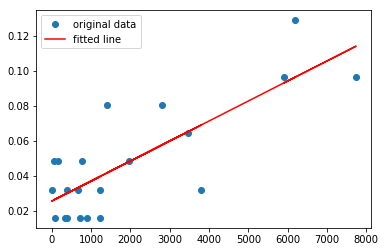

In [266]:
plt.plot(x, y, 'o', label='original data')
>>> plt.plot(x, intercept + slope*x, 'r', label='fitted line')
>>> plt.legend()
>>> plt.show()

In [267]:
copy_wins_dist_state = wins_and_dist_per_state.copy(deep=True)
copy_wins_dist_state = copy_wins_dist_state[['Proportion of Wins Per State', 'dist_wteam']]
# copy_wins_dist_state.columns = ['y', 'x']
copy_wins_dist_state.head()

,Proportion of Wins Per State,dist_wteam
0,0.129032,6179.641558
1,0.096774,5898.673494
2,0.096774,7740.386791
3,0.080645,1418.181587
4,0.080645,2799.798283


Text(0.5, 1.0, 'Proportion of Wins Per State vs. Distance Traveled For Winning Team')

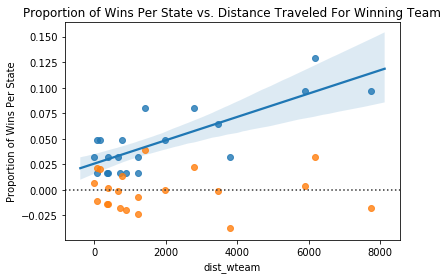

In [268]:
ax = sns.regplot(x="dist_wteam", y="Proportion of Wins Per State", data=copy_wins_dist_state).set_title(
    'Proportion of Wins Per State vs. Distance Traveled For Winning Team'
);
ax2 = sns.residplot(x="dist_wteam", y="Proportion of Wins Per State", data=copy_wins_dist_state);
ax

In [269]:
temp = copy_wins_dist_state.copy(deep=True)
# temp['Proportion of Winning Teams Per State'] = temp['Proportion of Winning Teams Per State'].apply(lambda x: np.log(x))
temp['dist_wteam'] = temp['dist_wteam'].apply(lambda x: np.log(x))

Text(0.5, 1.0, 'Proportion of Wins Per State vs. Log of Distance Traveled For Winning Team')

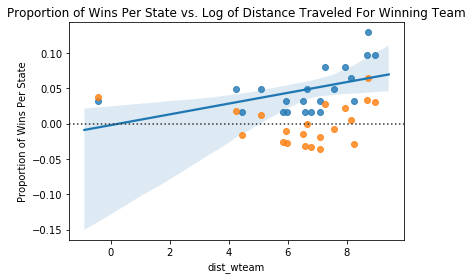

In [270]:
ax = sns.regplot(x="dist_wteam", y="Proportion of Wins Per State", data=temp).set_title(
    'Proportion of Wins Per State vs. Log of Distance Traveled For Winning Team'
);
ax2 = sns.residplot(x="dist_wteam", y="Proportion of Wins Per State", data=temp);
ax

In [82]:
tot_dist_per_team = master_tourney_2010.groupby('institution name')['dist_wteam'].sum().sort_values(ascending=False).reset_index()
tot_dist_per_team.columns = ['Team', 'dist_wteam']
tot_dist_per_team.head()

,Team,dist_wteam
0,connecticut college,5898.673494
1,baylor university,4468.068012
2,georgia institute of technology main campus,3802.959358
3,san diego state university,2669.088968
4,georgetown college,2604.795484


In [83]:
wins_and_dist_per_team = pd.merge(prop_wins_per_team, tot_dist_per_team)
wins_and_dist_per_team.head()

# x = wins_and_dist_per_team['dist_wteam']
# y = wins_and_dist_per_team['Proportion of Wins Per Team']

# slope, intercept, r_value, p_value, std_err = linregress(x, y)
# >>> print("slope: %f    intercept: %f" % (slope, intercept))

# print("r-squared: %f" % r_value**2)

# plt.plot(x, y, 'o', label='original data')
# >>> plt.plot(x, intercept + slope*x, 'r', label='fitted line')
# >>> plt.legend()
# >>> plt.show()

,Team,Proportion of Wins Per Team,dist_wteam
0,connecticut college,0.095238,5898.673494
1,oklahoma state university main campus,0.079365,1418.181587
2,stanford university,0.079365,1767.550029
3,baylor university,0.063492,4468.068012
4,university of kentucky,0.047619,851.904201


In [84]:
x = wins_and_dist_per_team['dist_wteam']
y = wins_and_dist_per_team['Proportion of Wins Per Team']

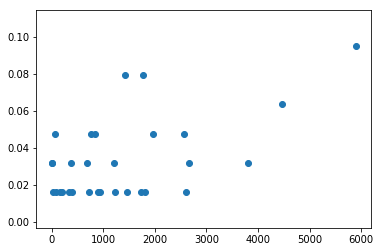

In [85]:
plt.scatter(x, y)

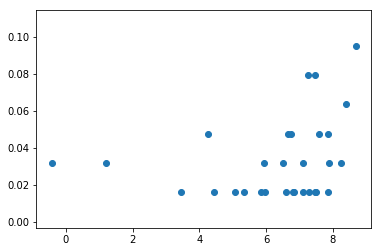

In [86]:
plt.scatter(x.apply(lambda x: np.log(x)), y)

In [87]:
slope, intercept, r_value, p_value, std_err = linregress(x, y)
>>> print("slope: %f    intercept: %f" % (slope, intercept))

slope: 0.000009    intercept: 0.021516


In [88]:
print("r-squared: %f" % r_value**2)

r-squared: 0.301981


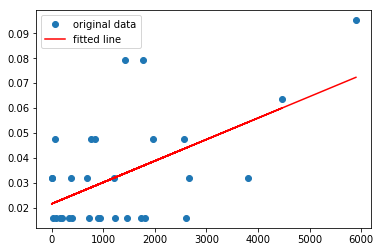

In [89]:
plt.plot(x, y, 'o', label='original data')
>>> plt.plot(x, intercept + slope*x, 'r', label='fitted line')
>>> plt.legend()
>>> plt.show()

In [90]:
copy_wins_dist = wins_and_dist_per_team.copy(deep=True)
copy_wins_dist = copy_wins_dist[['Proportion of Wins Per Team', 'dist_wteam']]
copy_wins_dist.columns = ['y', 'x']
copy_wins_dist.head()

,y,x
0,0.095238,5898.673494
1,0.079365,1418.181587
2,0.079365,1767.550029
3,0.063492,4468.068012
4,0.047619,851.904201


In [91]:
result = sm.ols(formula="y ~ x", data=copy_wins_dist).fit()

In [92]:
>>> print(result.params)

Intercept    0.021516
x            0.000009
dtype: float64


In [93]:
>>> print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     12.11
Date:                Sun, 24 Mar 2019   Prob (F-statistic):            0.00166
Time:                        11:23:58   Log-Likelihood:                 77.570
No. Observations:                  30   AIC:                            -151.1
Df Residuals:                      28   BIC:                            -148.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0215      0.005      4.448      0.0

In [273]:
copy_wins_dist = wins_and_dist_per_team.copy(deep=True)
copy_wins_dist = copy_wins_dist[['Proportion of Wins Per Team', 'dist_wteam']]
copy_wins_dist.head()

# ax = sns.regplot(x="dist_wteam", y="Proportion of Wins Per Team", data=copy_wins_dist).set_title(
#     'Proportion of Wins Per Team vs. Distance Traveled For Winning Team'
# );
# ax2 = sns.residplot(x="dist_wteam", y="Proportion of Wins Per Team", data=copy_wins_dist);
# ax

# temp = copy_wins_dist.copy(deep=True)
# # temp['Proportion of Wins Per Team'] = temp['Proportion of Wins Per Team'].apply(lambda x: np.log(x))
# temp['dist_wteam'] = temp['dist_wteam'].apply(lambda x: np.log(x))

# ax = sns.regplot(x="dist_wteam", y="Proportion of Wins Per Team", data=temp).set_title(
#     'Proportion of Wins Per Team vs. Log of Distance Traveled For Winning Team'
# );
# ax2 = sns.residplot(x="dist_wteam", y="Proportion of Wins Per Team", data=temp);
# ax

,Proportion of Wins Per Team,dist_wteam
0,0.095238,5898.673494
1,0.079365,1418.181587
2,0.079365,1767.550029
3,0.063492,4468.068012
4,0.047619,851.904201


Text(0.5, 1.0, 'Proportion of Wins Per Team vs. Distance Traveled For Winning Team')

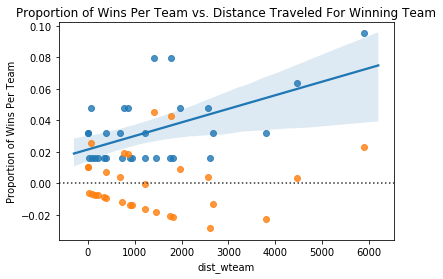

In [274]:
ax = sns.regplot(x="dist_wteam", y="Proportion of Wins Per Team", data=copy_wins_dist).set_title(
    'Proportion of Wins Per Team vs. Distance Traveled For Winning Team'
);
ax2 = sns.residplot(x="dist_wteam", y="Proportion of Wins Per Team", data=copy_wins_dist);
ax

In [287]:
temp = copy_wins_dist.copy(deep=True)
# temp['Proportion of Wins Per Team'] = temp['Proportion of Wins Per Team'].apply(lambda x: np.log(x))
temp['dist_wteam'] = temp['dist_wteam'].apply(lambda x: np.log(x))

Text(0.5, 1.0, 'Proportion of Wins Per Team vs. Log of Distance Traveled For Winning Team')

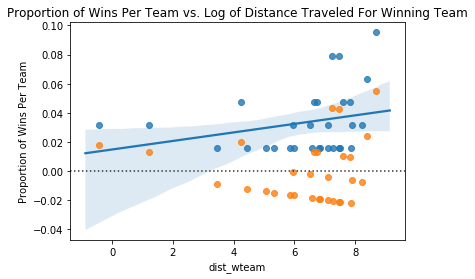

In [289]:
ax = sns.regplot(x="dist_wteam", y="Proportion of Wins Per Team", data=temp).set_title(
    'Proportion of Wins Per Team vs. Log of Distance Traveled For Winning Team'
);
ax2 = sns.residplot(x="dist_wteam", y="Proportion of Wins Per Team", data=temp);
ax

- No linear relationship since residuals are NOT nearly normal
- therefore, we can't use linear regression for distance travelled vs. win %

In [160]:
teams_distances = tourney_2010_final_with_dist[['dist_wteam', 'dist_lteam']]
teams_distances.head()

,dist_wteam,dist_lteam
0,1740.981153,178.551039
1,31.128287,925.736490
2,2.304251,177.802553
3,2.710048,579.766893
4,2604.795484,3336.251260


In [308]:
print(
    'Total Distance Traveled in Miles for All Winning Teams: ', 
    teams_distances['dist_wteam'].sum()
)
print(
    'Total Distance Traveled in Miles for All Losing Teams:  ', 
    teams_distances['dist_lteam'].sum()
)

Total Distance Traveled in Miles for All Winning Teams:  44103.34931506775
Total Distance Traveled in Miles for All Losing Teams:   49196.96226732179


True     0.650794
False    0.349206
dtype: float64

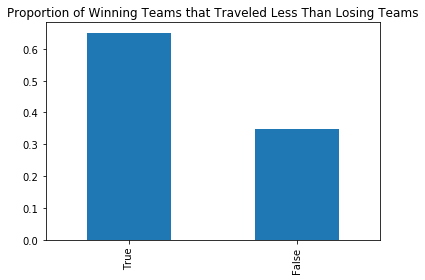

In [291]:
display((teams_distances['dist_wteam'] < teams_distances['dist_lteam']).value_counts(normalize=True))
(
    teams_distances['dist_wteam'] < teams_distances['dist_lteam']
).value_counts(
        normalize=True
    ).plot(
        kind='bar',
        title='Proportion of Winning Teams that Traveled Less Than Losing Teams',
        x='Boolean Values',
        y='Proportion'
    )

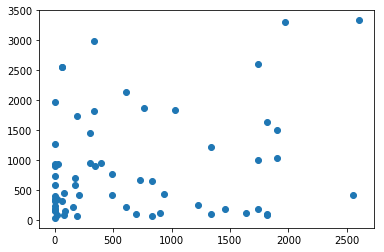

In [161]:
plt.scatter(teams_distances['dist_wteam'], teams_distances['dist_lteam'])

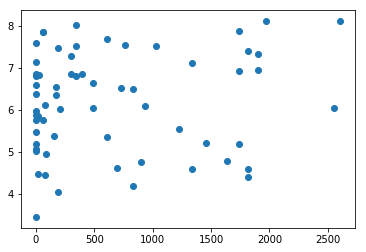

In [300]:
plt.scatter(
    teams_distances['dist_wteam'],#.apply(lambda x: np.log(x)), 
    teams_distances['dist_lteam'].apply(lambda x: np.log(x))
)

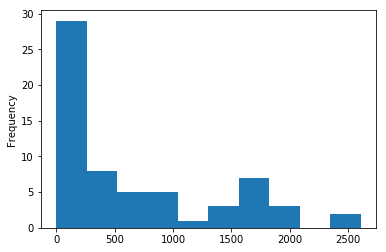

In [294]:
(
    teams_distances['dist_wteam']#.apply(np.mean)
    .plot(kind='hist')
)

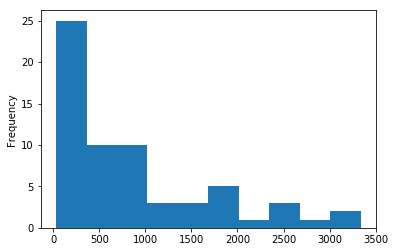

In [295]:
(
    teams_distances['dist_lteam']
    .plot(kind='hist')
)

In [85]:
# TODO: Compute the same statistics for all losing teams

### Working with the 2011 Season

In [97]:
# working with just the 2011 season of the NCAA tournament
tourney_2011 = tourney_compact.loc[tourney_compact['Season'] == 2011]
tourney_2011 = tourney_2011.reset_index(drop=True)
display(len(tourney_2011))
tourney_2011.head()

63

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT
0,2011,138,depaul,56,military,43,N,0
1,2011,138,duke,90,martin,45,H,0
2,2011,138,georgia institute,69,bowling green,58,N,0
3,2011,138,gonzaga,92,iowa,86,H,0
4,2011,138,kentucky,66,hampton,62,N,1


In [98]:
wteams_df = get_wteams_with_coords(tourney_2011)
display(len(wteams_df))
display(wteams_df.head())

63

,institution name,latitude,longitude,unitid,year,wteam_coord
0,depaul university,41.877618,-87.627240,144740.0,2017.0,"[-87.62724, 41.877618]"
1,duke university,36.001135,-78.937624,198419.0,2017.0,"[-78.937624, 36.001135]"
2,georgia institute of technology main campus,33.772420,-84.394832,139755.0,2017.0,"[-84.394832, 33.772420000000004]"
3,gonzaga university,47.666531,-117.400625,235316.0,2017.0,"[-117.400625, 47.666531]"
4,university of kentucky,38.038911,-84.504747,157085.0,2017.0,"[-84.504747, 38.038911]"


In [99]:
tourney_2011_wteam_coords = pd.concat([tourney_2011, wteams_df], axis=1)
tourney_2011_wteam_coords.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,unitid,year,wteam_coord
0,2011,138,depaul,56,military,43,N,0,depaul university,41.877618,-87.627240,144740.0,2017.0,"[-87.62724, 41.877618]"
1,2011,138,duke,90,martin,45,H,0,duke university,36.001135,-78.937624,198419.0,2017.0,"[-78.937624, 36.001135]"
2,2011,138,georgia institute,69,bowling green,58,N,0,georgia institute of technology main campus,33.772420,-84.394832,139755.0,2017.0,"[-84.394832, 33.772420000000004]"
3,2011,138,gonzaga,92,iowa,86,H,0,gonzaga university,47.666531,-117.400625,235316.0,2017.0,"[-117.400625, 47.666531]"
4,2011,138,kentucky,66,hampton,62,N,1,university of kentucky,38.038911,-84.504747,157085.0,2017.0,"[-84.504747, 38.038911]"


In [100]:
lteams_df = get_lteams_with_coords(tourney_2011)
display(len(lteams_df))
display(lteams_df.head())

63

,institution name,latitude,longitude,unitid,year,lteam_coord
0,united states military academy,41.390479,-73.956603,197036.0,2017.0,"[-73.956603, 41.390479]"
1,the university of tennessee martin,36.340338,-88.864211,221768.0,2017.0,"[-88.864211, 36.340338]"
2,bowling green state university main campus,41.375513,-83.640896,201441.0,2017.0,"[-83.640896, 41.375513]"
3,iowa state university,42.026212,-93.648504,153603.0,2017.0,"[-93.648504, 42.026212]"
4,hampton university,37.019944,-76.339161,232265.0,2017.0,"[-76.339161, 37.019944]"


In [101]:
tourney_2011_lteam_coords = pd.concat([tourney_2011, lteams_df], axis=1)
tourney_2011_lteam_coords.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,unitid,year,lteam_coord
0,2011,138,depaul,56,military,43,N,0,united states military academy,41.390479,-73.956603,197036.0,2017.0,"[-73.956603, 41.390479]"
1,2011,138,duke,90,martin,45,H,0,the university of tennessee martin,36.340338,-88.864211,221768.0,2017.0,"[-88.864211, 36.340338]"
2,2011,138,georgia institute,69,bowling green,58,N,0,bowling green state university main campus,41.375513,-83.640896,201441.0,2017.0,"[-83.640896, 41.375513]"
3,2011,138,gonzaga,92,iowa,86,H,0,iowa state university,42.026212,-93.648504,153603.0,2017.0,"[-93.648504, 42.026212]"
4,2011,138,kentucky,66,hampton,62,N,1,hampton university,37.019944,-76.339161,232265.0,2017.0,"[-76.339161, 37.019944]"


In [102]:
tourney_2011_game_locations = merged_gc_usc.loc[merged_gc_usc['Season'] == 2011]
tourney_2011_game_locations = tourney_2011_game_locations[['City', 'State', 'city&state', 'latitude', 'longitude']]
tourney_2011_game_locations.head()

,City,State,city&state,latitude,longitude
63,University Park,PA,University ParkPA,40.8122,-77.8561
64,Durham,NC,DurhamNC,35.9801,-78.9045
65,Columbus,OH,ColumbusOH,39.9859,-82.9852
66,Spokane,WA,SpokaneWA,47.6671,-117.433
67,Albuquerque,NM,AlbuquerqueNM,35.1055,-106.648


In [103]:
tourney_2011_game_locations['game_loc_coord'] = [ 
    [ 
        tourney_2011_game_locations['longitude'].values[index], 
        tourney_2011_game_locations['latitude'].values[index] 
    ] for index in range(len(tourney_2011_game_locations)) 
]
tourney_2011_game_locations = tourney_2011_game_locations.reset_index().drop('index', axis=1)
tourney_2011_game_locations.head()

,City,State,city&state,latitude,longitude,game_loc_coord
0,University Park,PA,University ParkPA,40.8122,-77.8561,"[-77.856102, 40.812195]"
1,Durham,NC,DurhamNC,35.9801,-78.9045,"[-78.9045, 35.9801]"
2,Columbus,OH,ColumbusOH,39.9859,-82.9852,"[-82.9852, 39.9859]"
3,Spokane,WA,SpokaneWA,47.6671,-117.433,"[-117.433, 47.6671]"
4,Albuquerque,NM,AlbuquerqueNM,35.1055,-106.648,"[-106.6476, 35.1055]"


In [104]:
tourney_2011_teams_coords = pd.concat([tourney_2011_wteam_coords, lteams_df], axis=1)
tourney_2011_teams_coords = tourney_2011_teams_coords.drop(['unitid', 'year'], axis=1)
tourney_2011_teams_coords.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,wteam_coord,institution name,latitude,longitude,lteam_coord
0,2011,138,depaul,56,military,43,N,0,depaul university,41.877618,-87.627240,"[-87.62724, 41.877618]",united states military academy,41.390479,-73.956603,"[-73.956603, 41.390479]"
1,2011,138,duke,90,martin,45,H,0,duke university,36.001135,-78.937624,"[-78.937624, 36.001135]",the university of tennessee martin,36.340338,-88.864211,"[-88.864211, 36.340338]"
2,2011,138,georgia institute,69,bowling green,58,N,0,georgia institute of technology main campus,33.772420,-84.394832,"[-84.394832, 33.772420000000004]",bowling green state university main campus,41.375513,-83.640896,"[-83.640896, 41.375513]"
3,2011,138,gonzaga,92,iowa,86,H,0,gonzaga university,47.666531,-117.400625,"[-117.400625, 47.666531]",iowa state university,42.026212,-93.648504,"[-93.648504, 42.026212]"
4,2011,138,kentucky,66,hampton,62,N,1,university of kentucky,38.038911,-84.504747,"[-84.504747, 38.038911]",hampton university,37.019944,-76.339161,"[-76.339161, 37.019944]"


In [105]:
tourney_2011_final = pd.concat([tourney_2011_teams_coords, tourney_2011_game_locations], axis=1)
tourney_2011_final.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,...,institution name,latitude,longitude,lteam_coord,City,State,city&state,latitude,longitude,game_loc_coord
0,2011,138,depaul,56,military,43,N,0,depaul university,41.877618,...,united states military academy,41.390479,-73.956603,"[-73.956603, 41.390479]",University Park,PA,University ParkPA,40.8122,-77.8561,"[-77.856102, 40.812195]"
1,2011,138,duke,90,martin,45,H,0,duke university,36.001135,...,the university of tennessee martin,36.340338,-88.864211,"[-88.864211, 36.340338]",Durham,NC,DurhamNC,35.9801,-78.9045,"[-78.9045, 35.9801]"
2,2011,138,georgia institute,69,bowling green,58,N,0,georgia institute of technology main campus,33.772420,...,bowling green state university main campus,41.375513,-83.640896,"[-83.640896, 41.375513]",Columbus,OH,ColumbusOH,39.9859,-82.9852,"[-82.9852, 39.9859]"
3,2011,138,gonzaga,92,iowa,86,H,0,gonzaga university,47.666531,...,iowa state university,42.026212,-93.648504,"[-93.648504, 42.026212]",Spokane,WA,SpokaneWA,47.6671,-117.433,"[-117.433, 47.6671]"
4,2011,138,kentucky,66,hampton,62,N,1,university of kentucky,38.038911,...,hampton university,37.019944,-76.339161,"[-76.339161, 37.019944]",Albuquerque,NM,AlbuquerqueNM,35.1055,-106.648,"[-106.6476, 35.1055]"


In [106]:
tourney_2011_all_coords = tourney_2011_final[['wteam_coord', 'lteam_coord', 'game_loc_coord']]
tourney_2011_all_coords.head()

,wteam_coord,lteam_coord,game_loc_coord
0,"[-87.62724, 41.877618]","[-73.956603, 41.390479]","[-77.856102, 40.812195]"
1,"[-78.937624, 36.001135]","[-88.864211, 36.340338]","[-78.9045, 35.9801]"
2,"[-84.394832, 33.772420000000004]","[-83.640896, 41.375513]","[-82.9852, 39.9859]"
3,"[-117.400625, 47.666531]","[-93.648504, 42.026212]","[-117.433, 47.6671]"
4,"[-84.504747, 38.038911]","[-76.339161, 37.019944]","[-106.6476, 35.1055]"


In [107]:
dist_wteam_df, dist_lteam_df = get_distances(tourney_2011_all_coords)
display(dist_wteam_df.head())
display(dist_lteam_df.head())

,dist_wteam
0,674.753137
1,2.304251
2,108.021584
3,2.235636
4,1528.634111


,dist_lteam
0,269.440987
1,687.741131
2,46.632276
3,1643.762647
4,2092.566621


In [108]:
tourney_2011_final_with_dist = pd.concat([tourney_2011_final, dist_wteam_df, dist_lteam_df], axis=1)
tourney_2011_final_with_dist.T

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
Season,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
DayNum,138,138,138,138,138,138,138,138,138,138,...,146,146,146,147,147,148,148,153,153,155
WTeam,depaul,duke,georgia institute,gonzaga,kentucky,marist,marquette,north carolina,notre dame,ohio st,...,connecticut,duke,texas a m,notre dame,stanford,connecticut,texas a m,notre dame,texas a m,texas a m
WScore,56,90,69,92,66,74,68,82,67,80,...,68,70,79,73,83,75,58,72,63,76
LTeam,military,martin,bowling green,iowa,hampton,iowa st,texas,fresno,utah,central florida,...,georgetown,depaul,georgia,tennessee,gonzaga,duke,baylor,connecticut,stanford,notre dame
LScore,43,45,58,86,62,64,65,68,54,69,...,63,63,38,59,60,40,46,63,62,70
WLoc,N,H,N,H,N,N,N,N,A,H,...,N,N,H,N,N,N,A,N,N,N
NumOT,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
institution name,depaul university,duke university,georgia institute of technology main campus,gonzaga university,university of kentucky,marist college,marquette university,north carolina central university,university of notre dame,ohio state university main campus,...,connecticut college,duke university,texas a m university college station,university of notre dame,stanford university,connecticut college,texas a m university college station,university of notre dame,texas a m university college station,texas a m university college station
latitude,41.8776,36.0011,33.7724,47.6665,38.0389,41.7209,43.039,35.9742,41.7031,39.9993,...,41.3798,36.0011,30.6187,41.7031,37.4294,41.3798,30.6187,41.7031,30.6187,30.6187


In [109]:
wteam_distances = get_wteam_distances(tourney_2011_final_with_dist)
wteam_distances[:5]

[[[-87.62724, 41.877618], [-77.856102, 40.812195]],
 [[-78.937624, 36.001135], [-78.9045, 35.9801]],
 [[-84.394832, 33.772420000000004], [-82.9852, 39.9859]],
 [[-117.400625, 47.666531], [-117.433, 47.6671]],
 [[-84.504747, 38.038911], [-106.6476, 35.1055]]]

In [110]:
wteam_dict = create_wteam_dict(wteam_distances)
wteam_dict

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'title': 'Travel Distance for Each Winning Team',
    'description': 'A line representing the entire route'},
   'geometry': {'type': 'MultiLineString',
    'coordinates': [[[-87.62724, 41.877618], [-77.856102, 40.812195]],
     [[-78.937624, 36.001135], [-78.9045, 35.9801]],
     [[-84.394832, 33.772420000000004], [-82.9852, 39.9859]],
     [[-117.400625, 47.666531], [-117.433, 47.6671]],
     [[-84.504747, 38.038911], [-106.6476, 35.1055]],
     [[-73.935484, 41.720937], [-78.9045, 35.9801]],
     [[-87.927961, 43.03903], [-83.9498, 35.969]],
     [[-78.898602, 35.974237], [-106.6476, 35.1055]],
     [[-86.238959, 41.703058], [-111.9301, 40.7774]],
     [[-83.014853, 39.999324], [-82.9852, 39.9859]],
     [[-77.862848, 40.7965], [-77.856102, 40.812195]],
     [[-73.796104, 40.722522999999995], [-122.1674, 37.4252]],
     [[-122.167359, 37.429434], [-122.1674, 37.4252]],
     [[-97.350471, 31.07071500000

In [111]:
citystates = tourney_2011_final_with_dist['city&state'].values.tolist()
citystates[:5]

['University ParkPA', 'DurhamNC', 'ColumbusOH', 'SpokaneWA', 'AlbuquerqueNM']

In [112]:
with open('WDataFiles/wteam_data_2011.json', 'w') as outfile:
    json.dump(wteam_dict, outfile)

In [113]:
institutions = tourney_2011_final_with_dist['institution name'].values.tolist()
institutions[:5] #[0]

[['depaul university', 'united states military academy'],
 ['duke university', 'the university of tennessee martin'],
 ['georgia institute of technology main campus',
  'bowling green state university main campus'],
 ['gonzaga university', 'iowa state university'],
 ['university of kentucky', 'hampton university']]

In [114]:
#GeoJSON
wteams_route = os.path.join('WDataFiles', 'wteam_data_2011.json')

m2011_win = folium.Map(
    location=[32.88354, -117.23486],
    tiles='Mapbox Bright',
    zoom_start=2
)

folium.GeoJson(
    wteams_route,
    name='geojson'
).add_to(m2011_win)

# create a marker
#  location
# pop-up: when you click on the marker, what should appear. Can contain HTML tags
# Tooltip: what you see when you hoover over
# and then add it to the map
#add markers
for index in range(len(wteam_distances)):
    wteam_coords     = wteam_distances[index][0]
    wteam_coords     = [wteam_coords[1], wteam_coords[0]]
    game_loc_coords  = wteam_distances[index][1]
    game_loc_coords  = [game_loc_coords[1], game_loc_coords[0]]
    institution_name = institutions[index][0]
    game_loc_name    = citystates[index]
    folium.Marker(
        wteam_coords, 
        popup = institution_name, 
        tooltip="Click to see institution name", 
        icon=folium.Icon(color='red', icon='pencil')
    ).add_to(m2011_win)
    folium.Marker(
        game_loc_coords, 
        popup = game_loc_name, 
        tooltip="Click to see game location", 
        icon=folium.Icon(color='darkblue', icon='plane')
    ).add_to(m2011_win)

m2011_win

In [115]:
lteam_distances = get_lteam_distances(tourney_2011_final_with_dist)
lteam_distances[:5]

[[[-73.956603, 41.390479], [-77.856102, 40.812195]],
 [[-88.864211, 36.340338], [-78.9045, 35.9801]],
 [[-83.640896, 41.375513], [-82.9852, 39.9859]],
 [[-93.648504, 42.026212], [-117.433, 47.6671]],
 [[-76.339161, 37.019944], [-106.6476, 35.1055]]]

In [116]:
lteam_dict = create_lteam_dict(lteam_distances)
lteam_dict

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'title': 'Travel Distance for Each Losing Team',
    'description': 'A line representing the entire route'},
   'geometry': {'type': 'MultiLineString',
    'coordinates': [[[-73.956603, 41.390479], [-77.856102, 40.812195]],
     [[-88.864211, 36.340338], [-78.9045, 35.9801]],
     [[-83.640896, 41.375513], [-82.9852, 39.9859]],
     [[-93.648504, 42.026212], [-117.433, 47.6671]],
     [[-76.339161, 37.019944], [-106.6476, 35.1055]],
     [[-93.648504, 42.026212], [-78.9045, 35.9801]],
     [[-96.336475, 30.618726000000002], [-83.9498, 35.969]],
     [[-119.748258, 36.814477000000004], [-106.6476, 35.1055]],
     [[-111.84604399999999, 40.762484], [-111.9301, 40.7774]],
     [[-81.200889, 28.602159000000004], [-82.9852, 39.9859]],
     [[-84.176113, 39.739546999999995], [-77.856102, 40.812195]],
     [[-101.874783, 33.583448], [-122.1674, 37.4252]],
     [[-121.749567, 38.539667], [-122.1674, 37.4252]],
  

In [117]:
with open('WDataFiles/lteam_data_2011.json', 'w') as outfile:
    json.dump(lteam_dict, outfile)

In [118]:
#GeoJSON
lteams_route = os.path.join('WDataFiles', 'lteam_data_2011.json')

m2011_lose = folium.Map(
    location=[32.88354, -117.23486],
    tiles='Mapbox Bright',
    zoom_start=2
)

folium.GeoJson(
    lteams_route,
    name='geojson'
).add_to(m2011_lose)

# create a marker
#  location
# pop-up: when you click on the marker, what should appear. Can contain HTML tags
# Tooltip: what you see when you hoover over
# and then add it to the map
#add markers
for index in range(len(lteam_distances)):
    lteam_coords     = lteam_distances[index][0]
    lteam_coords     = [lteam_coords[1], lteam_coords[0]]
    game_loc_coords  = lteam_distances[index][1]
    game_loc_coords  = [game_loc_coords[1], game_loc_coords[0]]
    institution_name = institutions[index][1]
    game_loc_name    = citystates[index]
    folium.Marker(
        lteam_coords, 
        popup = institution_name, 
        tooltip="Click to see institution name", 
        icon=folium.Icon(color='red', icon='pencil')
    ).add_to(m2011_lose)
    folium.Marker(
        game_loc_coords, 
        popup = game_loc_name, 
        tooltip="Click to see game location", 
        icon=folium.Icon(color='darkblue', icon='plane')
    ).add_to(m2011_lose)

m2011_lose

### Working with the 2017 Season

In [119]:
# working with just the 2017 season of the NCAA tournament
tourney_2017 = tourney_compact.loc[tourney_compact['Season'] == 2017]
tourney_2017 = tourney_2017.reset_index(drop=True)
display(len(tourney_2017))
tourney_2017.head()

63

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT
0,2017,137,arizona st,73,michigan st,61,N,0
1,2017,137,creighton,76,toledo,49,N,0
2,2017,137,depaul,88,northern iowa,67,N,0
3,2017,137,florida st,87,western illinois,66,H,0
4,2017,137,kentucky,73,belmont,70,H,0


In [120]:
wteams_df = get_wteams_with_coords(tourney_2017)
display(len(wteams_df))
display(wteams_df.head())

63

,institution name,latitude,longitude,unitid,year,wteam_coord
0,arizona state university tempe,33.417721,-111.934383,104151.0,2017.0,"[-111.93438300000001, 33.417721]"
1,creighton university,41.265361,-95.947811,181002.0,2017.0,"[-95.947811, 41.265361]"
2,depaul university,41.877618,-87.627240,144740.0,2017.0,"[-87.62724, 41.877618]"
3,florida state university,30.440756,-84.291921,134097.0,2017.0,"[-84.291921, 30.440756]"
4,university of kentucky,38.038911,-84.504747,157085.0,2017.0,"[-84.504747, 38.038911]"


In [121]:
tourney_2017_wteam_coords = pd.concat([tourney_2017, wteams_df], axis=1)
tourney_2017_wteam_coords.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,unitid,year,wteam_coord
0,2017,137,arizona st,73,michigan st,61,N,0,arizona state university tempe,33.417721,-111.934383,104151.0,2017.0,"[-111.93438300000001, 33.417721]"
1,2017,137,creighton,76,toledo,49,N,0,creighton university,41.265361,-95.947811,181002.0,2017.0,"[-95.947811, 41.265361]"
2,2017,137,depaul,88,northern iowa,67,N,0,depaul university,41.877618,-87.627240,144740.0,2017.0,"[-87.62724, 41.877618]"
3,2017,137,florida st,87,western illinois,66,H,0,florida state university,30.440756,-84.291921,134097.0,2017.0,"[-84.291921, 30.440756]"
4,2017,137,kentucky,73,belmont,70,H,0,university of kentucky,38.038911,-84.504747,157085.0,2017.0,"[-84.504747, 38.038911]"


In [122]:
lteams_df = get_lteams_with_coords(tourney_2017)
display(len(lteams_df))
display(lteams_df.head())

63

,institution name,latitude,longitude,unitid,year,lteam_coord
0,michigan state university,42.732120,-84.476111,171100.0,2017.0,"[-84.476111, 42.73212]"
1,university of toledo,41.660572,-83.614714,206084.0,2017.0,"[-83.614714, 41.660571999999995]"
2,university of northern iowa,42.514923,-92.459703,154095.0,2017.0,"[-92.459703, 42.514922999999996]"
3,western illinois university,40.468086,-90.686899,149772.0,2017.0,"[-90.686899, 40.468086]"
4,belmont university,36.133866,-86.794715,219709.0,2017.0,"[-86.794715, 36.133866]"


In [123]:
tourney_2017_lteam_coords = pd.concat([tourney_2017, lteams_df], axis=1)
tourney_2017_lteam_coords.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,unitid,year,lteam_coord
0,2017,137,arizona st,73,michigan st,61,N,0,michigan state university,42.732120,-84.476111,171100.0,2017.0,"[-84.476111, 42.73212]"
1,2017,137,creighton,76,toledo,49,N,0,university of toledo,41.660572,-83.614714,206084.0,2017.0,"[-83.614714, 41.660571999999995]"
2,2017,137,depaul,88,northern iowa,67,N,0,university of northern iowa,42.514923,-92.459703,154095.0,2017.0,"[-92.459703, 42.514922999999996]"
3,2017,137,florida st,87,western illinois,66,H,0,western illinois university,40.468086,-90.686899,149772.0,2017.0,"[-90.686899, 40.468086]"
4,2017,137,kentucky,73,belmont,70,H,0,belmont university,36.133866,-86.794715,219709.0,2017.0,"[-86.794715, 36.133866]"


In [124]:
tourney_2017_game_locations = merged_gc_usc.loc[merged_gc_usc['Season'] == 2017]
tourney_2017_game_locations = tourney_2017_game_locations[['City', 'State', 'city&state', 'latitude', 'longitude']]
tourney_2017_game_locations.head()

,City,State,city&state,latitude,longitude
441,Columbia,SC,ColumbiaSC,34.0366,-80.9043
442,Corvallis,OR,CorvallisOR,44.5697,-123.278
443,Starkville,MS,StarkvilleMS,33.4608,-88.8297
444,Tallahassee,FL,TallahasseeFL,30.4549,-84.2527
445,Lexington,KY,LexingtonKY,38.0423,-84.4587


In [125]:
tourney_2017_game_locations['game_loc_coord'] = [ 
    [ 
        tourney_2017_game_locations['longitude'].values[index], 
        tourney_2017_game_locations['latitude'].values[index] 
    ] for index in range(len(tourney_2017_game_locations)) 
]
tourney_2017_game_locations = tourney_2017_game_locations.reset_index().drop('index', axis=1)
tourney_2017_game_locations.head()

,City,State,city&state,latitude,longitude,game_loc_coord
0,Columbia,SC,ColumbiaSC,34.0366,-80.9043,"[-80.9043, 34.0366]"
1,Corvallis,OR,CorvallisOR,44.5697,-123.278,"[-123.2781, 44.5697]"
2,Starkville,MS,StarkvilleMS,33.4608,-88.8297,"[-88.8297, 33.4608]"
3,Tallahassee,FL,TallahasseeFL,30.4549,-84.2527,"[-84.2527, 30.4549]"
4,Lexington,KY,LexingtonKY,38.0423,-84.4587,"[-84.4587, 38.0423]"


In [126]:
tourney_2017_teams_coords = pd.concat([tourney_2017_wteam_coords, lteams_df], axis=1)
tourney_2017_teams_coords = tourney_2017_teams_coords.drop(['unitid', 'year'], axis=1)
tourney_2017_teams_coords.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,wteam_coord,institution name,latitude,longitude,lteam_coord
0,2017,137,arizona st,73,michigan st,61,N,0,arizona state university tempe,33.417721,-111.934383,"[-111.93438300000001, 33.417721]",michigan state university,42.732120,-84.476111,"[-84.476111, 42.73212]"
1,2017,137,creighton,76,toledo,49,N,0,creighton university,41.265361,-95.947811,"[-95.947811, 41.265361]",university of toledo,41.660572,-83.614714,"[-83.614714, 41.660571999999995]"
2,2017,137,depaul,88,northern iowa,67,N,0,depaul university,41.877618,-87.627240,"[-87.62724, 41.877618]",university of northern iowa,42.514923,-92.459703,"[-92.459703, 42.514922999999996]"
3,2017,137,florida st,87,western illinois,66,H,0,florida state university,30.440756,-84.291921,"[-84.291921, 30.440756]",western illinois university,40.468086,-90.686899,"[-90.686899, 40.468086]"
4,2017,137,kentucky,73,belmont,70,H,0,university of kentucky,38.038911,-84.504747,"[-84.504747, 38.038911]",belmont university,36.133866,-86.794715,"[-86.794715, 36.133866]"


In [127]:
tourney_2017_final = pd.concat([tourney_2017_teams_coords, tourney_2017_game_locations], axis=1)
tourney_2017_final.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,...,institution name,latitude,longitude,lteam_coord,City,State,city&state,latitude,longitude,game_loc_coord
0,2017,137,arizona st,73,michigan st,61,N,0,arizona state university tempe,33.417721,...,michigan state university,42.732120,-84.476111,"[-84.476111, 42.73212]",Columbia,SC,ColumbiaSC,34.0366,-80.9043,"[-80.9043, 34.0366]"
1,2017,137,creighton,76,toledo,49,N,0,creighton university,41.265361,...,university of toledo,41.660572,-83.614714,"[-83.614714, 41.660571999999995]",Corvallis,OR,CorvallisOR,44.5697,-123.278,"[-123.2781, 44.5697]"
2,2017,137,depaul,88,northern iowa,67,N,0,depaul university,41.877618,...,university of northern iowa,42.514923,-92.459703,"[-92.459703, 42.514922999999996]",Starkville,MS,StarkvilleMS,33.4608,-88.8297,"[-88.8297, 33.4608]"
3,2017,137,florida st,87,western illinois,66,H,0,florida state university,30.440756,...,western illinois university,40.468086,-90.686899,"[-90.686899, 40.468086]",Tallahassee,FL,TallahasseeFL,30.4549,-84.2527,"[-84.2527, 30.4549]"
4,2017,137,kentucky,73,belmont,70,H,0,university of kentucky,38.038911,...,belmont university,36.133866,-86.794715,"[-86.794715, 36.133866]",Lexington,KY,LexingtonKY,38.0423,-84.4587,"[-84.4587, 38.0423]"


In [128]:
tourney_2017_all_coords = tourney_2017_final[['wteam_coord', 'lteam_coord', 'game_loc_coord']]
tourney_2017_all_coords.head()

,wteam_coord,lteam_coord,game_loc_coord
0,"[-111.93438300000001, 33.417721]","[-84.476111, 42.73212]","[-80.9043, 34.0366]"
1,"[-95.947811, 41.265361]","[-83.614714, 41.660571999999995]","[-123.2781, 44.5697]"
2,"[-87.62724, 41.877618]","[-92.459703, 42.514922999999996]","[-88.8297, 33.4608]"
3,"[-84.291921, 30.440756]","[-90.686899, 40.468086]","[-84.2527, 30.4549]"
4,"[-84.504747, 38.038911]","[-86.794715, 36.133866]","[-84.4587, 38.0423]"


In [129]:
dist_wteam_df, dist_lteam_df = get_distances(tourney_2017_all_coords)
display(dist_wteam_df.head())
display(dist_lteam_df.head())

,dist_wteam
0,2142.667346
1,1888.029503
2,84.732066
3,2.710048
4,3.179724


,dist_lteam
0,257.510021
1,2738.354372
2,249.976081
3,443.649153
4,161.597278


In [130]:
tourney_2017_final_with_dist = pd.concat([tourney_2017_final, dist_wteam_df, dist_lteam_df], axis=1)
tourney_2017_final_with_dist.T

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
Season,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
DayNum,137,137,137,137,137,137,137,137,137,137,...,145,145,145,146,146,147,147,151,151,153
WTeam,arizona st,creighton,depaul,florida st,kentucky,maryland,mississippi st,missouri,north carolina state,notre dame,...,florida st,oregon,south carolina,mississippi st,stanford,connecticut,south carolina,mississippi st,south carolina,south carolina
WScore,73,76,88,87,73,103,110,66,62,79,...,66,77,100,94,76,90,71,66,62,67
LTeam,michigan st,toledo,northern iowa,western illinois,belmont,bucknell,troy,south florida,auburn,robert morris,...,oregon st,maryland,quinnipiac,baylor,notre dame,oregon,florida st,connecticut,stanford,mississippi st
LScore,61,49,67,66,70,61,69,64,48,49,...,53,63,58,85,75,52,64,64,53,55
WLoc,N,N,N,H,H,H,H,N,N,H,...,N,N,N,N,N,H,N,N,N,N
NumOT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
institution name,arizona state university tempe,creighton university,depaul university,florida state university,university of kentucky,university of maryland college park,mississippi state university,university of missouri kansas city,north carolina state university at raleigh,university of notre dame,...,florida state university,oregon state university,university of south carolina columbia,mississippi state university,stanford university,connecticut college,university of south carolina columbia,mississippi state university,university of south carolina columbia,university of south carolina columbia
latitude,33.4177,41.2654,41.8776,30.4408,38.0389,38.9882,33.4549,39.0342,35.7851,41.7031,...,30.4408,44.5639,33.9968,33.4549,37.4294,41.3798,33.9968,33.4549,33.9968,33.9968


In [131]:
wteam_distances = get_wteam_distances(tourney_2017_final_with_dist)
wteam_distances[:5]

[[[-111.93438300000001, 33.417721], [-80.9043, 34.0366]],
 [[-95.947811, 41.265361], [-123.2781, 44.5697]],
 [[-87.62724, 41.877618], [-88.8297, 33.4608]],
 [[-84.291921, 30.440756], [-84.2527, 30.4549]],
 [[-84.504747, 38.038911], [-84.4587, 38.0423]]]

In [132]:
wteam_dict = create_wteam_dict(wteam_distances)
wteam_dict

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'title': 'Travel Distance for Each Winning Team',
    'description': 'A line representing the entire route'},
   'geometry': {'type': 'MultiLineString',
    'coordinates': [[[-111.93438300000001, 33.417721], [-80.9043, 34.0366]],
     [[-95.947811, 41.265361], [-123.2781, 44.5697]],
     [[-87.62724, 41.877618], [-88.8297, 33.4608]],
     [[-84.291921, 30.440756], [-84.2527, 30.4549]],
     [[-84.504747, 38.038911], [-84.4587, 38.0423]],
     [[-76.944721, 38.988178000000005], [-76.9337, 38.9964]],
     [[-88.790139, 33.454852], [-88.8297, 33.4608]],
     [[-94.58214100000001, 39.034178999999995], [-84.2527, 30.4549]],
     [[-78.67451700000001, 35.785111], [-97.7545, 30.3038]],
     [[-86.238959, 41.703058], [-86.234192, 41.702358]],
     [[-83.014853, 39.999324], [-84.4587, 38.0423]],
     [[-123.274723, 44.56395], [-123.2781, 44.5697]],
     [[-86.914435, 40.428206], [-86.234192, 41.702358]],
     [[-8

In [133]:
citystates = tourney_2017_final_with_dist['city&state'].values.tolist()
citystates[:5]

['ColumbiaSC', 'CorvallisOR', 'StarkvilleMS', 'TallahasseeFL', 'LexingtonKY']

In [134]:
with open('WDataFiles/wteam_data_2017.json', 'w') as outfile:
    json.dump(wteam_dict, outfile)

In [135]:
institutions = tourney_2017_final_with_dist['institution name'].values.tolist()
institutions[:5] #[0]

[['arizona state university tempe', 'michigan state university'],
 ['creighton university', 'university of toledo'],
 ['depaul university', 'university of northern iowa'],
 ['florida state university', 'western illinois university'],
 ['university of kentucky', 'belmont university']]

In [136]:
#GeoJSON
wteams_route = os.path.join('WDataFiles', 'wteam_data_2017.json')

m2017_win = folium.Map(
    location=[32.88354, -117.23486],
    tiles='Mapbox Bright',
    zoom_start=2
)

folium.GeoJson(
    wteams_route,
    name='geojson'
).add_to(m2017_win)

# create a marker
#  location
# pop-up: when you click on the marker, what should appear. Can contain HTML tags
# Tooltip: what you see when you hoover over
# and then add it to the map
#add markers
for index in range(len(wteam_distances)):
    wteam_coords     = wteam_distances[index][0]
    wteam_coords     = [wteam_coords[1], wteam_coords[0]]
    game_loc_coords  = wteam_distances[index][1]
    game_loc_coords  = [game_loc_coords[1], game_loc_coords[0]]
    institution_name = institutions[index][0]
    game_loc_name    = citystates[index]
    folium.Marker(
        wteam_coords, 
        popup = institution_name, 
        tooltip="Click to see institution name", 
        icon=folium.Icon(color='red', icon='pencil')
    ).add_to(m2017_win)
    folium.Marker(
        game_loc_coords, 
        popup = game_loc_name, 
        tooltip="Click to see game location", 
        icon=folium.Icon(color='darkblue', icon='plane')
    ).add_to(m2017_win)

m2017_win

In [137]:
lteam_distances = get_lteam_distances(tourney_2017_final_with_dist)
lteam_distances[:5]

[[[-84.476111, 42.73212], [-80.9043, 34.0366]],
 [[-83.614714, 41.660571999999995], [-123.2781, 44.5697]],
 [[-92.459703, 42.514922999999996], [-88.8297, 33.4608]],
 [[-90.686899, 40.468086], [-84.2527, 30.4549]],
 [[-86.794715, 36.133866], [-84.4587, 38.0423]]]

In [138]:
lteam_dict = create_lteam_dict(lteam_distances)
lteam_dict

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'title': 'Travel Distance for Each Losing Team',
    'description': 'A line representing the entire route'},
   'geometry': {'type': 'MultiLineString',
    'coordinates': [[[-84.476111, 42.73212], [-80.9043, 34.0366]],
     [[-83.614714, 41.660571999999995], [-123.2781, 44.5697]],
     [[-92.459703, 42.514922999999996], [-88.8297, 33.4608]],
     [[-90.686899, 40.468086], [-84.2527, 30.4549]],
     [[-86.794715, 36.133866], [-84.4587, 38.0423]],
     [[-76.882616, 40.954316999999996], [-76.9337, 38.9964]],
     [[-85.957094, 31.800672], [-88.8297, 33.4608]],
     [[-82.413232, 28.061458000000002], [-84.2527, 30.4549]],
     [[-85.488258, 32.599378], [-97.7545, 30.3038]],
     [[-87.62706800000001, 41.876278000000006], [-86.234192, 41.702358]],
     [[-86.456828, 36.985034999999996], [-84.4587, 38.0423]],
     [[-118.11204, 33.782818], [-123.2781, 44.5697]],
     [[-87.919973, 44.532298], [-86.234192, 41.7

In [139]:
with open('WDataFiles/lteam_data_2017.json', 'w') as outfile:
    json.dump(lteam_dict, outfile)

In [140]:
#GeoJSON
lteams_route = os.path.join('WDataFiles', 'lteam_data_2017.json')

m2017_lose = folium.Map(
    location=[32.88354, -117.23486],
    tiles='Mapbox Bright',
    zoom_start=2
)

folium.GeoJson(
    lteams_route,
    name='geojson'
).add_to(m2017_lose)

# create a marker
#  location
# pop-up: when you click on the marker, what should appear. Can contain HTML tags
# Tooltip: what you see when you hoover over
# and then add it to the map
#add markers
for index in range(len(lteam_distances)):
    lteam_coords     = lteam_distances[index][0]
    lteam_coords     = [lteam_coords[1], lteam_coords[0]]
    game_loc_coords  = lteam_distances[index][1]
    game_loc_coords  = [game_loc_coords[1], game_loc_coords[0]]
    institution_name = institutions[index][1]
    game_loc_name    = citystates[index]
    folium.Marker(
        lteam_coords, 
        popup = institution_name, 
        tooltip="Click to see institution name", 
        icon=folium.Icon(color='red', icon='pencil')
    ).add_to(m2017_lose)
    folium.Marker(
        game_loc_coords, 
        popup = game_loc_name, 
        tooltip="Click to see game location", 
        icon=folium.Icon(color='darkblue', icon='plane')
    ).add_to(m2017_lose)

m2017_lose

In [353]:
teams_distances = tourney_2017_final_with_dist[['dist_wteam', 'dist_lteam']]
teams_distances.head()

,dist_wteam,dist_lteam
0,2142.667346,257.510021
1,1888.029503,2738.354372
2,84.732066,249.976081
3,2.710048,443.649153
4,3.179724,161.597278


In [354]:
print(
    'Total Distance Traveled in Miles for All Winning Teams: ', 
    teams_distances['dist_wteam'].sum()
)
print(
    'Total Distance Traveled in Miles for All Losing Teams:  ', 
    teams_distances['dist_lteam'].sum()
)

Total Distance Traveled in Miles for All Winning Teams:  44103.34931506775
Total Distance Traveled in Miles for All Losing Teams:   49196.96226732179


True     0.650794
False    0.349206
dtype: float64

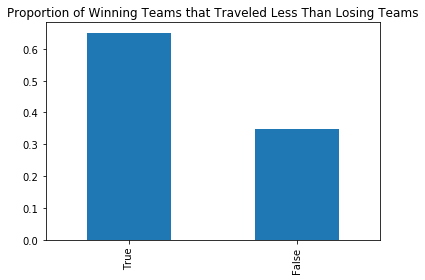

In [305]:
display((teams_distances['dist_wteam'] < teams_distances['dist_lteam']).value_counts(normalize=True))
(
    teams_distances['dist_wteam'] < teams_distances['dist_lteam']
).value_counts(
        normalize=True
    ).plot(
        kind='bar',
        title='Proportion of Winning Teams that Traveled Less Than Losing Teams',
        x='Boolean Values',
        y='Proportion'
    )

In [310]:
tourney_2017_teams_coords

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,wteam_coord,institution name,latitude,longitude,lteam_coord
0,2017,137,arizona st,73,michigan st,61,N,0,arizona state university tempe,33.417721,-111.934383,"[-111.93438300000001, 33.417721]",michigan state university,42.732120,-84.476111,"[-84.476111, 42.73212]"
1,2017,137,creighton,76,toledo,49,N,0,creighton university,41.265361,-95.947811,"[-95.947811, 41.265361]",university of toledo,41.660572,-83.614714,"[-83.614714, 41.660571999999995]"
2,2017,137,depaul,88,northern iowa,67,N,0,depaul university,41.877618,-87.627240,"[-87.62724, 41.877618]",university of northern iowa,42.514923,-92.459703,"[-92.459703, 42.514922999999996]"
3,2017,137,florida st,87,western illinois,66,H,0,florida state university,30.440756,-84.291921,"[-84.291921, 30.440756]",western illinois university,40.468086,-90.686899,"[-90.686899, 40.468086]"
4,2017,137,kentucky,73,belmont,70,H,0,university of kentucky,38.038911,-84.504747,"[-84.504747, 38.038911]",belmont university,36.133866,-86.794715,"[-86.794715, 36.133866]"
5,2017,137,maryland,103,bucknell,61,H,0,university of maryland college park,38.988178,-76.944721,"[-76.944721, 38.988178000000005]",bucknell university,40.954317,-76.882616,"[-76.882616, 40.954316999999996]"
6,2017,137,mississippi st,110,troy,69,H,0,mississippi state university,33.454852,-88.790139,"[-88.790139, 33.454852]",troy university,31.800672,-85.957094,"[-85.957094, 31.800672]"
7,2017,137,missouri,66,south florida,64,N,0,university of missouri kansas city,39.034179,-94.582141,"[-94.58214100000001, 39.034178999999995]",university of south florida main campus,28.061458,-82.413232,"[-82.413232, 28.061458000000002]"
8,2017,137,north carolina state,62,auburn,48,N,0,north carolina state university at raleigh,35.785111,-78.674517,"[-78.67451700000001, 35.785111]",auburn university,32.599378,-85.488258,"[-85.488258, 32.599378]"
9,2017,137,notre dame,79,robert morris,49,H,0,university of notre dame,41.703058,-86.238959,"[-86.238959, 41.703058]",robert morris university illinois,41.876278,-87.627068,"[-87.62706800000001, 41.876278000000006]"


In [313]:
tourney_2017_wteam_states = tourney_2017_wteam_coords.merge(all_wteams_with_states, how='left')
display(len(tourney_2017_wteam_states))
tourney_2017_wteam_states.head()

63

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,unitid,year,wteam_coord,institution name alias,city,state
0,2017,137,arizona st,73,michigan st,61,N,0,arizona state university tempe,33.417721,-111.934383,104151.0,2017.0,"[-111.93438300000001, 33.417721]","ASU Tempe, ASU Main",Tempe,Arizona
1,2017,137,creighton,76,toledo,49,N,0,creighton university,41.265361,-95.947811,181002.0,2017.0,"[-95.947811, 41.265361]",NaN,Omaha,Nebraska
2,2017,137,depaul,88,northern iowa,67,N,0,depaul university,41.877618,-87.627240,144740.0,2017.0,"[-87.62724, 41.877618]",NaN,Chicago,Illinois
3,2017,137,florida st,87,western illinois,66,H,0,florida state university,30.440756,-84.291921,134097.0,2017.0,"[-84.291921, 30.440756]",Florida State|F.S.U.|FSU|F. S. U.|Fla. State U...,Tallahassee,Florida
4,2017,137,kentucky,73,belmont,70,H,0,university of kentucky,38.038911,-84.504747,157085.0,2017.0,"[-84.504747, 38.038911]",NaN,Lexington,Kentucky


In [319]:
tourney_2017_wteam_states['institution name'].value_counts().head()

university of south carolina columbia    6
oregon state university                  5
mississippi state university             5
stanford university                      4
connecticut college                      4
Name: institution name, dtype: int64

In [314]:
prop_wins_per_team = tourney_2017_wteam_states['institution name'].value_counts(normalize=True).to_frame().reset_index()
prop_wins_per_team.columns = ['Team', 'Proportion of Wins Per Team']
prop_wins_per_team.head()

,Team,Proportion of Wins Per Team
0,university of south carolina columbia,0.095238
1,oregon state university,0.079365
2,mississippi state university,0.079365
3,stanford university,0.063492
4,connecticut college,0.063492


In [321]:
# # wins_and_dist_per_team = 
# pd.concat([prop_wins_per_team, teams_distances['dist_wteam']], axis=1)
# # wins_and_dist_per_team.head()
master_tourney_2017 = pd.concat([tourney_2017_wteam_states, tourney_2017_final_with_dist['dist_wteam']], axis=1)
master_tourney_2017.head()

,Season,DayNum,WTeam,WScore,LTeam,LScore,WLoc,NumOT,institution name,latitude,longitude,unitid,year,wteam_coord,institution name alias,city,state,dist_wteam
0,2017,137,arizona st,73,michigan st,61,N,0,arizona state university tempe,33.417721,-111.934383,104151.0,2017.0,"[-111.93438300000001, 33.417721]","ASU Tempe, ASU Main",Tempe,Arizona,2142.667346
1,2017,137,creighton,76,toledo,49,N,0,creighton university,41.265361,-95.947811,181002.0,2017.0,"[-95.947811, 41.265361]",NaN,Omaha,Nebraska,1888.029503
2,2017,137,depaul,88,northern iowa,67,N,0,depaul university,41.877618,-87.627240,144740.0,2017.0,"[-87.62724, 41.877618]",NaN,Chicago,Illinois,84.732066
3,2017,137,florida st,87,western illinois,66,H,0,florida state university,30.440756,-84.291921,134097.0,2017.0,"[-84.291921, 30.440756]",Florida State|F.S.U.|FSU|F. S. U.|Fla. State U...,Tallahassee,Florida,2.710048
4,2017,137,kentucky,73,belmont,70,H,0,university of kentucky,38.038911,-84.504747,157085.0,2017.0,"[-84.504747, 38.038911]",NaN,Lexington,Kentucky,3.179724


In [322]:
tot_dist_per_state = master_tourney_2017.groupby('state')['dist_wteam'].sum().sort_values(ascending=False).reset_index()
tot_dist_per_state.columns = ['State', 'dist_wteam']
tot_dist_per_state.head()

,State,dist_wteam
0,California,10479.480141
1,Oregon,9571.601072
2,South Carolina,7751.482387
3,Florida,2561.846413
4,Arizona,2142.667346


In [324]:
# tourney_2010_wteam_states.groupby('state')#.value_counts()
prop_wteams_per_state = tourney_2017_wteam_states['state'].value_counts(normalize=True).to_frame().reset_index()
prop_wteams_per_state.columns = ['State', 'Proportion of Wins Per State']
prop_wteams_per_state.head()

,State,Proportion of Wins Per State
0,California,0.111111
1,Texas,0.095238
2,Connecticut,0.095238
3,South Carolina,0.095238
4,Mississippi,0.079365


In [329]:
wins_and_dist_per_state = pd.merge(prop_wteams_per_state, tot_dist_per_state)
wins_and_dist_per_state.head()

,State,Proportion of Wins Per State,dist_wteam
0,California,0.111111,10479.480141
1,Texas,0.095238,1774.665454
2,Connecticut,0.095238,1305.287466
3,South Carolina,0.095238,7751.482387
4,Mississippi,0.079365,1760.888375


In [330]:
teams_distances = tourney_2017_final_with_dist[['dist_wteam', 'dist_lteam']]
teams_distances.head()

,dist_wteam,dist_lteam
0,2142.667346,257.510021
1,1888.029503,2738.354372
2,84.732066,249.976081
3,2.710048,443.649153
4,3.179724,161.597278


slope: 0.000007    intercept: 0.031239
r-squared: 0.433938


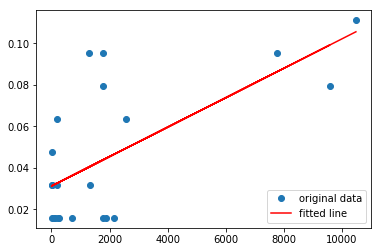

In [332]:
x = wins_and_dist_per_state['dist_wteam']
y = wins_and_dist_per_state['Proportion of Wins Per State']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))

print("r-squared: %f" % r_value**2)

plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

In [333]:
copy_wins_dist_state = wins_and_dist_per_state.copy(deep=True)
copy_wins_dist_state = copy_wins_dist_state[['Proportion of Wins Per State', 'dist_wteam']]
# copy_wins_dist_state.columns = ['y', 'x']
copy_wins_dist_state.head()

,Proportion of Wins Per State,dist_wteam
0,0.111111,10479.480141
1,0.095238,1774.665454
2,0.095238,1305.287466
3,0.095238,7751.482387
4,0.079365,1760.888375


Text(0.5, 1.0, 'Proportion of Wins Per State vs. Distance Traveled For Winning Team')

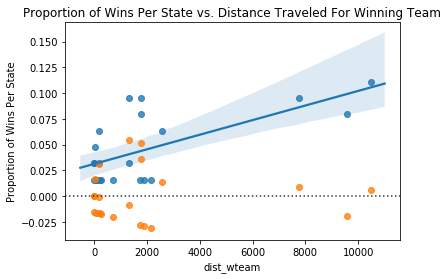

In [334]:
ax = sns.regplot(x="dist_wteam", y="Proportion of Wins Per State", data=copy_wins_dist_state).set_title(
    'Proportion of Wins Per State vs. Distance Traveled For Winning Team'
);
ax2 = sns.residplot(x="dist_wteam", y="Proportion of Wins Per State", data=copy_wins_dist_state);
ax

In [341]:
temp = copy_wins_dist_state.copy(deep=True)
# temp['Proportion of Wins Per State'] = temp['Proportion of Wins Per State'].apply(lambda x: np.log(x))
temp['dist_wteam'] = temp['dist_wteam'].apply(lambda x: np.log(x))

Text(0.5, 1.0, 'Proportion of Wins Per State vs. Log of Distance Traveled For Winning Team')

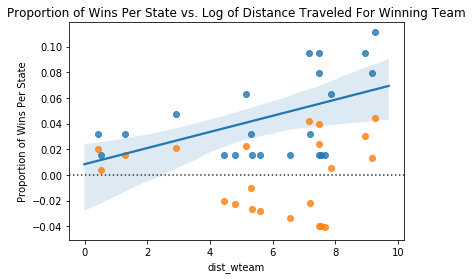

In [342]:
ax = sns.regplot(x="dist_wteam", y="Proportion of Wins Per State", data=temp).set_title(
    'Proportion of Wins Per State vs. Log of Distance Traveled For Winning Team'
);
ax2 = sns.residplot(x="dist_wteam", y="Proportion of Wins Per State", data=temp);
ax

In [343]:
# Same analysis for 2017 season, for each team

In [344]:
tot_dist_per_team = master_tourney_2017.groupby('institution name')['dist_wteam'].sum().sort_values(ascending=False).reset_index()
tot_dist_per_team.columns = ['Team', 'dist_wteam']
tot_dist_per_team.head()

,Team,dist_wteam
0,oregon state university,9571.601072
1,stanford university,8738.490006
2,university of south carolina columbia,7751.482387
3,florida state university,2558.738801
4,arizona state university tempe,2142.667346


,Team,Proportion of Wins Per Team,dist_wteam
0,university of south carolina columbia,0.095238,7751.482387
1,oregon state university,0.079365,9571.601072
2,mississippi state university,0.079365,1760.888375
3,stanford university,0.063492,8738.490006
4,connecticut college,0.063492,177.712279


slope: 0.000006    intercept: 0.024593
r-squared: 0.447937


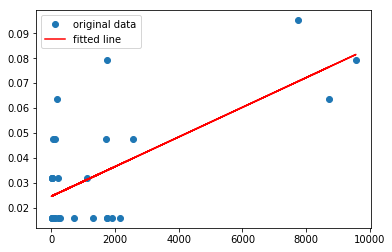

In [347]:
wins_and_dist_per_team = pd.merge(prop_wins_per_team, tot_dist_per_team)
display(wins_and_dist_per_team.head())

x = wins_and_dist_per_team['dist_wteam']
y = wins_and_dist_per_team['Proportion of Wins Per Team']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))

print("r-squared: %f" % r_value**2)

plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

In [346]:
copy_wins_dist = wins_and_dist_per_team.copy(deep=True)
copy_wins_dist = copy_wins_dist[['Proportion of Wins Per Team', 'dist_wteam']]
copy_wins_dist.head()

,Proportion of Wins Per Team,dist_wteam
0,0.095238,7751.482387
1,0.079365,9571.601072
2,0.079365,1760.888375
3,0.063492,8738.490006
4,0.063492,177.712279


Text(0.5, 1.0, 'Proportion of Wins Per Team vs. Distance Traveled For Winning Team')

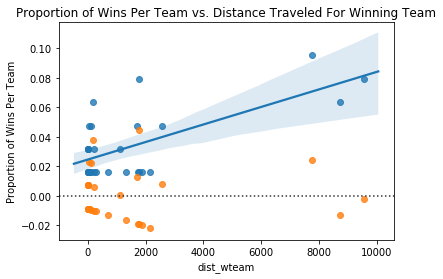

In [348]:
ax = sns.regplot(x="dist_wteam", y="Proportion of Wins Per Team", data=copy_wins_dist).set_title(
    'Proportion of Wins Per Team vs. Distance Traveled For Winning Team'
);
ax2 = sns.residplot(x="dist_wteam", y="Proportion of Wins Per Team", data=copy_wins_dist);
ax

In [349]:
temp = copy_wins_dist.copy(deep=True)
# temp['Proportion of Wins Per Team'] = temp['Proportion of Wins Per Team'].apply(lambda x: np.log(x))
temp['dist_wteam'] = temp['dist_wteam'].apply(lambda x: np.log(x))

Text(0.5, 1.0, 'Proportion of Wins Per Team vs. Log of Distance Traveled For Winning Team')

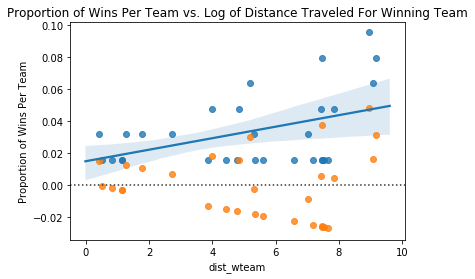

In [350]:
ax = sns.regplot(x="dist_wteam", y="Proportion of Wins Per Team", data=temp).set_title(
    'Proportion of Wins Per Team vs. Log of Distance Traveled For Winning Team'
);
ax2 = sns.residplot(x="dist_wteam", y="Proportion of Wins Per Team", data=temp);
ax

## Calculating Total Distance Travelled to Each Winning Team's Institution

In [141]:
def haversine(df):
    '''haversine in miles'''
    rads = df.applymap(np.deg2rad)

    lat1 = rads['latitude']
    long1 = rads['longitude']

    # To take successive difference, shift arrays up by one.
    lat2 = rads['latitude'].iloc[1:].reset_index(drop=True)
    long2 = rads['longitude'].iloc[1:].reset_index(drop=True)

    lat = lat2 - lat1
    long = long2 - long1
    
    inside = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(long * 0.5) ** 2
    return 2 * 6371.0088 * np.arcsin(np.sqrt(inside)) * 0.621

In [142]:
# haversine distance for winning teams in NCAA tournament
print('Approximate total distance traveled during the NCAA tournament in miles: ') 
display(haversine(updated_all_wteams[['latitude', 'longitude']]).sum())
# updated_all_wteams[['latitude', 'longitude']].head()

Approximate total distance traveled during the NCAA tournament in miles: 


38499.37154024012

In [143]:
# haversine distance for losing teams in NCAA tournament
print('Approximate total distance traveled during the NCAA tournament in miles: ') 
display(haversine(updated_all_lteams[['latitude', 'longitude']]).sum())
# updated_all_lteams[['latitude', 'longitude']].head()

Approximate total distance traveled during the NCAA tournament in miles: 


67789.83956871075

In [144]:
# haversine distance for cities where NCAA tournament games were played
print('Approximate total distance traveled during the NCAA tournament in miles: ') 
display(haversine(game_cities_coord[['latitude', 'longitude']]).sum())
# updated_all_lteams[['latitude', 'longitude']].head()

Approximate total distance traveled during the NCAA tournament in miles: 


558315.5076742548

## Making The Choropleth Map of the Proportion of Games Per State

In [145]:
college_path = os.path.join('WDataFiles', 'MERGED2016_17_PP.csv')
college = pd.read_csv(college_path)
college.head()

,UNITID,OPEID,OPEID6,INSTNM,ZIP,CITY,STABBR,LATITUDE,LONGITUDE,INSTURL,...,RET_FT4_POOLED_SUPP,RET_FTL4_POOLED_SUPP,RET_PT4_POOLED_SUPP,RET_PTL4_POOLED_SUPP,PCTFLOAN,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP,RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP
0,100654,100200,1002,Alabama A & M University,35762,Normal,AL,34.783368,-86.568502,www.aamu.edu/,...,0.5774,NaN,0.309,NaN,0.7667,32750,348.16551225731,0.2531554273,NaN,0.2913
1,100663,105200,1052,University of Alabama at Birmingham,35294-0110,Birmingham,AL,33.505697,-86.799345,www.uab.edu,...,0.8007,NaN,0.5178,NaN,0.5179,21833,232.106797835537,0.513963161,NaN,0.5384
2,100690,2503400,25034,Amridge University,36117-3553,Montgomery,AL,32.362609,-86.174010,www.amridgeuniversity.edu,...,PrivacySuppressed,NaN,PrivacySuppressed,NaN,0.8436,22890,243.343773299842,0.2307692308,NaN,PrivacySuppressed
3,100706,105500,1055,University of Alabama in Huntsville,35899,Huntsville,AL,34.724557,-86.640449,www.uah.edu,...,0.8161,NaN,0.5116,NaN,0.4312,22647,240.760438353933,0.5485090298,NaN,0.4905
4,100724,100500,1005,Alabama State University,36104-0271,Montgomery,AL,32.364317,-86.295677,www.alasu.edu,...,0.6138,NaN,0.5313,NaN,0.8113,31500,334.876752247489,0.2185867473,NaN,0.2475


In [146]:
students_per_state = college.groupby('STABBR')['UGDS'].apply(lambda x: sum(x))
students_per_state = students_per_state.to_frame()
students_per_state.head()

,UGDS
STABBR,
AK,20378
AL,243683
AR,127021
AS,1246
AZ,464620


In [147]:
# read in WDataFiles/state_fips
fips = os.path.join('WDataFiles', 'state_fips.txt')
fips_df = pd.read_csv(fips, sep='|')
fips_df = fips_df.merge(students_per_state, left_on='STUSAB', right_on='STABBR') #.head()
display(fips_df.head())

,STATE,STUSAB,STATE_NAME,STATENS,UGDS
0,1,AL,Alabama,1779775,243683
1,2,AK,Alaska,1785533,20378
2,4,AZ,Arizona,1779777,464620
3,5,AR,Arkansas,68085,127021
4,6,CA,California,1779778,2273897


In [148]:
# read in census populations: WDataFiles/population-2017.csv
states = os.path.join('WDataFiles', 'population-2017.csv')
states_df = pd.read_csv(states)
states_df.head()

,STATE,POP
0,AL,4874747
1,AK,739795
2,AZ,7016270
3,AR,3004279
4,CA,39536653


In [149]:
# merge fips_df with states_df
merged_df = fips_df.merge(states_df, left_on='STUSAB', right_on='STATE')
merged_df['PROP_COLLEGE'] = merged_df['UGDS'] / merged_df['POP']
# merged_df = merged_df.drop([51, 53])
# merged_df = merged_df[['STATE_x', 'PROP_COLLEGE']]
merged_df['STATE_x'] = merged_df['STATE_x'].astype(str).apply(lambda x: x.zfill(2))
merged_df.head()

,STATE_x,STUSAB,STATE_NAME,STATENS,UGDS,STATE_y,POP,PROP_COLLEGE
0,01,AL,Alabama,1779775,243683,AL,4874747,0.049989
1,02,AK,Alaska,1785533,20378,AK,739795,0.027545
2,04,AZ,Arizona,1779777,464620,AZ,7016270,0.066220
3,05,AR,Arkansas,68085,127021,AR,3004279,0.042280
4,06,CA,California,1779778,2273897,CA,39536653,0.057514


In [150]:
relevant_df = merged_df[['STATE_x', 'STUSAB', 'STATE_NAME']]
relevant_df = relevant_df.merge(game_cities, how='right', left_on='STUSAB', right_on='State')
# relevant_df

state_props = relevant_df['STATE_NAME'].value_counts(normalize=True).to_frame().reset_index() #.sum() #.groupby('STUSAB').describe()
state_props.columns = ['State', 'Proportion of Games in State']
display(len(state_props))
state_props.head()

35

,State,Proportion of Games in State
0,Texas,0.111111
1,California,0.084656
2,Kentucky,0.068783
3,North Carolina,0.063492
4,Ohio,0.058201


In [151]:
# read in geojson file WDataFiles/states.json
state_geo = os.path.join('WDataFiles', 'states.json')

In [152]:
# create states in GeoJSON
states = folium.Map(location=[48, -102], zoom_start = 3)
folium.GeoJson(state_geo, name = "states").add_to(states)
# states

In [153]:
# saves map to states.html
# states.save('states.html')

In [154]:
states.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_props,
    columns=['State', 'Proportion of Games in State'],
    key_on='feature.properties.NAME',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Proportion of Games Per State'
)

# states

C:\Users\redwa\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [155]:
# states.save('prop_games_by_state.html')

In [156]:
# create states in GeoJSON
states2 = folium.Map(location=[48, -102], zoom_start = 3)
folium.GeoJson(state_geo, name = "states").add_to(states2)
# states2

In [157]:
states2.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=prop_wteams_per_state,
    columns=['State', 'Proportion of Winning Teams Per State'],
    key_on='feature.properties.NAME',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Proportion of Winning Teams Per State'
)

# states2

In [158]:
# states2.save('prop_wteams_by_state.html')